### Imports

In [1]:
import torch
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd, 
    EnsureTyped,
    EnsureType,
    Invertd,
    KeepLargestConnectedComponent
)

# from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm

### Dataset

In [2]:
root_dir = "/scratch/scratch6/akansh12/Parse_data/train/train/"
train_images = sorted(glob.glob(os.path.join(root_dir, "*", 'image', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, "*", 'label', "*.nii.gz")))

data_dicts = [{"images": images_name, "labels": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]
set_determinism(seed = 0)

### Transforms

In [8]:
train_transforms = Compose(
    [
     LoadImaged(keys=['images', 'labels']),
     EnsureChannelFirstd(keys = ["images", "labels"]),
     Orientationd(keys=['images', 'labels'], axcodes = 'LPS'),
     Spacingd(keys=['images', 'labels'], pixdim = (1.5,1.5,2), mode = ("bilinear", 'nearest')),
     ScaleIntensityRanged(
            keys=["images"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
     CropForegroundd(keys=['images', 'labels'], source_key="images"),
     RandCropByPosNegLabeld(
            keys=['images', 'labels'],
            label_key="labels",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="images",
            image_threshold=0,
        ),
     EnsureTyped(keys=['images', 'labels']),     
          
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["images", "labels"]),
        EnsureChannelFirstd(keys=["images", "labels"]),
        Orientationd(keys=["images", "labels"], axcodes="LPS"),
        Spacingd(keys=["images", "labels"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["images"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["images", "labels"], source_key="images"),
        EnsureTyped(keys=["images", "labels"]),
    ]
)

### DataLoader

In [9]:
train_ds = CacheDataset(
    data = train_files, transform = train_transforms,
    cache_rate = 1.0, num_workers = 4
)

train_loader = DataLoader(train_ds, batch_size = 2, shuffle = True, num_workers=4)
val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 4
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=4)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.73s/it]


### Model defination

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
)
model = UNet(**UNet_meatdata).to(device)

In [6]:
model.load_state_dict(torch.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_baseline.pth"))

<All keys matched successfully>

### Loss function and Optimizers

In [7]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [8]:
Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f'param_group_{ind}'] = {key: value for (key, value) in param_group.items() if 'params' not in key}

In [9]:
max_epochs = 500
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])


slice_to_track = 80

for epoch in tqdm(range(max_epochs)):
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data['images'].to(device),
            batch_data['labels'].to(device)
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):

                val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model)

#                 output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_Unet_1000_hu.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                print(best_model_log_message)

                message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                message2 = f"\nbest mean dice: {best_metric:.4f} "
                message3 = f"at epoch: {best_metric_epoch}"
                print(message1, message2, message3)

# np.save("/scratch/scratch6/akansh12/challenges/parse2022/temp/epoch_loss.npy", epoch_loss_values)
# np.save("/scratch/scratch6/akansh12/challenges/parse2022/temp/metric_values.npy", metric_values)

  0%|          | 0/500 [00:00<?, ?it/s]

1/45, train_loss: 0.0825
2/45, train_loss: 0.1805
3/45, train_loss: 0.0704
4/45, train_loss: 0.0692
5/45, train_loss: 0.1654
6/45, train_loss: 0.0700
7/45, train_loss: 0.1261
8/45, train_loss: 0.1752
9/45, train_loss: 0.1335
10/45, train_loss: 0.0838
11/45, train_loss: 0.0726
12/45, train_loss: 0.1094
13/45, train_loss: 0.1288
14/45, train_loss: 0.0988
15/45, train_loss: 0.0670
16/45, train_loss: 0.0893
17/45, train_loss: 0.1458
18/45, train_loss: 0.0747
19/45, train_loss: 0.0785
20/45, train_loss: 0.1021
21/45, train_loss: 0.0830
22/45, train_loss: 0.1647
23/45, train_loss: 0.1056
24/45, train_loss: 0.0722
25/45, train_loss: 0.1090
26/45, train_loss: 0.0950
27/45, train_loss: 0.0719
28/45, train_loss: 0.0947
29/45, train_loss: 0.0728
30/45, train_loss: 0.0902
31/45, train_loss: 0.0749
32/45, train_loss: 0.1131
33/45, train_loss: 0.0670
34/45, train_loss: 0.1203
35/45, train_loss: 0.0932
36/45, train_loss: 0.0785
37/45, train_loss: 0.1285
38/45, train_loss: 0.0861
39/45, train_loss: 0.

36/45, train_loss: 0.1053
37/45, train_loss: 0.0891
38/45, train_loss: 0.0817
39/45, train_loss: 0.0804
40/45, train_loss: 0.1197
41/45, train_loss: 0.0710
42/45, train_loss: 0.1134
43/45, train_loss: 0.1326
44/45, train_loss: 0.1094
45/45, train_loss: 0.0689
46/45, train_loss: 0.0676
epoch 7 average loss: 0.0917
1/45, train_loss: 0.1177
2/45, train_loss: 0.0687
3/45, train_loss: 0.1233
4/45, train_loss: 0.1668
5/45, train_loss: 0.0714
6/45, train_loss: 0.0702
7/45, train_loss: 0.1166
8/45, train_loss: 0.0878
9/45, train_loss: 0.1267
10/45, train_loss: 0.0810
11/45, train_loss: 0.1450
12/45, train_loss: 0.1386
13/45, train_loss: 0.0707
14/45, train_loss: 0.0540
15/45, train_loss: 0.0646
16/45, train_loss: 0.0667
17/45, train_loss: 0.0752
18/45, train_loss: 0.0880
19/45, train_loss: 0.0969
20/45, train_loss: 0.1210
21/45, train_loss: 0.0907
22/45, train_loss: 0.0949
23/45, train_loss: 0.1218
24/45, train_loss: 0.0848
25/45, train_loss: 0.0831
26/45, train_loss: 0.1097
27/45, train_loss:

19/45, train_loss: 0.0732
20/45, train_loss: 0.1054
21/45, train_loss: 0.0526
22/45, train_loss: 0.0924
23/45, train_loss: 0.0734
24/45, train_loss: 0.0769
25/45, train_loss: 0.0894
26/45, train_loss: 0.0778
27/45, train_loss: 0.0889
28/45, train_loss: 0.0949
29/45, train_loss: 0.0744
30/45, train_loss: 0.1092
31/45, train_loss: 0.0815
32/45, train_loss: 0.0848
33/45, train_loss: 0.1026
34/45, train_loss: 0.1413
35/45, train_loss: 0.0771
36/45, train_loss: 0.0741
37/45, train_loss: 0.1211
38/45, train_loss: 0.0842
39/45, train_loss: 0.0638
40/45, train_loss: 0.0623
41/45, train_loss: 0.1747
42/45, train_loss: 0.0639
43/45, train_loss: 0.0671
44/45, train_loss: 0.0811
45/45, train_loss: 0.0688
46/45, train_loss: 0.0758
epoch 14 average loss: 0.0873
1/45, train_loss: 0.0812
2/45, train_loss: 0.0797
3/45, train_loss: 0.0675
4/45, train_loss: 0.0720
5/45, train_loss: 0.0725
6/45, train_loss: 0.0846
7/45, train_loss: 0.0824
8/45, train_loss: 0.0586
9/45, train_loss: 0.0890
10/45, train_loss

2/45, train_loss: 0.0724
3/45, train_loss: 0.0863
4/45, train_loss: 0.0743
5/45, train_loss: 0.0691
6/45, train_loss: 0.0711
7/45, train_loss: 0.0952
8/45, train_loss: 0.0657
9/45, train_loss: 0.0738
10/45, train_loss: 0.0694
11/45, train_loss: 0.0528
12/45, train_loss: 0.0578
13/45, train_loss: 0.0564
14/45, train_loss: 0.0543
15/45, train_loss: 0.1221
16/45, train_loss: 0.0602
17/45, train_loss: 0.0679
18/45, train_loss: 0.0840
19/45, train_loss: 0.0934
20/45, train_loss: 0.0823
21/45, train_loss: 0.1873
22/45, train_loss: 0.0687
23/45, train_loss: 0.0826
24/45, train_loss: 0.0657
25/45, train_loss: 0.1154
26/45, train_loss: 0.1012
27/45, train_loss: 0.0742
28/45, train_loss: 0.0845
29/45, train_loss: 0.0984
30/45, train_loss: 0.1143
31/45, train_loss: 0.0702
32/45, train_loss: 0.0701
33/45, train_loss: 0.0627
34/45, train_loss: 0.0701
35/45, train_loss: 0.1001
36/45, train_loss: 0.1323
37/45, train_loss: 0.0736
38/45, train_loss: 0.0910
39/45, train_loss: 0.1010
40/45, train_loss: 0

37/45, train_loss: 0.0575
38/45, train_loss: 0.0856
39/45, train_loss: 0.0759
40/45, train_loss: 0.1449
41/45, train_loss: 0.1251
42/45, train_loss: 0.1179
43/45, train_loss: 0.1355
44/45, train_loss: 0.1040
45/45, train_loss: 0.0593
46/45, train_loss: 0.0728
epoch 27 average loss: 0.0909
1/45, train_loss: 0.0660
2/45, train_loss: 0.1058
3/45, train_loss: 0.0718
4/45, train_loss: 0.0699
5/45, train_loss: 0.0898
6/45, train_loss: 0.0963
7/45, train_loss: 0.0878
8/45, train_loss: 0.1067
9/45, train_loss: 0.0726
10/45, train_loss: 0.0576
11/45, train_loss: 0.0740
12/45, train_loss: 0.0562
13/45, train_loss: 0.0527
14/45, train_loss: 0.0608
15/45, train_loss: 0.0785
16/45, train_loss: 0.0747
17/45, train_loss: 0.0913
18/45, train_loss: 0.0881
19/45, train_loss: 0.0822
20/45, train_loss: 0.0631
21/45, train_loss: 0.0597
22/45, train_loss: 0.0873
23/45, train_loss: 0.0666
24/45, train_loss: 0.0583
25/45, train_loss: 0.0515
26/45, train_loss: 0.0817
27/45, train_loss: 0.0614
28/45, train_loss

20/45, train_loss: 0.0682
21/45, train_loss: 0.0552
22/45, train_loss: 0.0934
23/45, train_loss: 0.0757
24/45, train_loss: 0.0717
25/45, train_loss: 0.0734
26/45, train_loss: 0.0695
27/45, train_loss: 0.0838
28/45, train_loss: 0.0895
29/45, train_loss: 0.0815
30/45, train_loss: 0.0717
31/45, train_loss: 0.1008
32/45, train_loss: 0.0933
33/45, train_loss: 0.0745
34/45, train_loss: 0.0736
35/45, train_loss: 0.0821
36/45, train_loss: 0.0884
37/45, train_loss: 0.0797
38/45, train_loss: 0.1053
39/45, train_loss: 0.1219
40/45, train_loss: 0.1042
41/45, train_loss: 0.1254
42/45, train_loss: 0.1037
43/45, train_loss: 0.0852
44/45, train_loss: 0.0739
45/45, train_loss: 0.0886
46/45, train_loss: 0.0975
epoch 34 average loss: 0.0831
1/45, train_loss: 0.1063
2/45, train_loss: 0.0798
3/45, train_loss: 0.0762
4/45, train_loss: 0.0631
5/45, train_loss: 0.0774
6/45, train_loss: 0.1623
7/45, train_loss: 0.0878
8/45, train_loss: 0.0786
9/45, train_loss: 0.0850
10/45, train_loss: 0.0867
11/45, train_loss

3/45, train_loss: 0.0852
4/45, train_loss: 0.0631
5/45, train_loss: 0.1125
6/45, train_loss: 0.0660
7/45, train_loss: 0.0680
8/45, train_loss: 0.1011
9/45, train_loss: 0.0726
10/45, train_loss: 0.0796
11/45, train_loss: 0.0666
12/45, train_loss: 0.0543
13/45, train_loss: 0.0781
14/45, train_loss: 0.1005
15/45, train_loss: 0.0923
16/45, train_loss: 0.0670
17/45, train_loss: 0.0601
18/45, train_loss: 0.0613
19/45, train_loss: 0.0924
20/45, train_loss: 0.0495
21/45, train_loss: 0.1196
22/45, train_loss: 0.0411
23/45, train_loss: 0.0917
24/45, train_loss: 0.0885
25/45, train_loss: 0.0708
26/45, train_loss: 0.1037
27/45, train_loss: 0.0721
28/45, train_loss: 0.0646
29/45, train_loss: 0.0631
30/45, train_loss: 0.0795
31/45, train_loss: 0.0809
32/45, train_loss: 0.0724
33/45, train_loss: 0.0531
34/45, train_loss: 0.0727
35/45, train_loss: 0.0822
36/45, train_loss: 0.0974
37/45, train_loss: 0.0826
38/45, train_loss: 0.0822
39/45, train_loss: 0.1023
40/45, train_loss: 0.0658
41/45, train_loss: 

38/45, train_loss: 0.0712
39/45, train_loss: 0.0643
40/45, train_loss: 0.0641
41/45, train_loss: 0.0667
42/45, train_loss: 0.0729
43/45, train_loss: 0.0657
44/45, train_loss: 0.0643
45/45, train_loss: 0.0789
46/45, train_loss: 0.0890
epoch 47 average loss: 0.0852
1/45, train_loss: 0.0742
2/45, train_loss: 0.0680
3/45, train_loss: 0.0540
4/45, train_loss: 0.0532
5/45, train_loss: 0.0813
6/45, train_loss: 0.0891
7/45, train_loss: 0.0998
8/45, train_loss: 0.0843
9/45, train_loss: 0.0961
10/45, train_loss: 0.1487
11/45, train_loss: 0.0721
12/45, train_loss: 0.1331
13/45, train_loss: 0.0510
14/45, train_loss: 0.0784
15/45, train_loss: 0.0701
16/45, train_loss: 0.0848
17/45, train_loss: 0.1282
18/45, train_loss: 0.0723
19/45, train_loss: 0.0824
20/45, train_loss: 0.0712
21/45, train_loss: 0.0913
22/45, train_loss: 0.0685
23/45, train_loss: 0.0578
24/45, train_loss: 0.1120
25/45, train_loss: 0.1014
26/45, train_loss: 0.0537
27/45, train_loss: 0.0654
28/45, train_loss: 0.0626
29/45, train_loss

21/45, train_loss: 0.0766
22/45, train_loss: 0.1065
23/45, train_loss: 0.0850
24/45, train_loss: 0.0803
25/45, train_loss: 0.1096
26/45, train_loss: 0.0870
27/45, train_loss: 0.0710
28/45, train_loss: 0.0934
29/45, train_loss: 0.0675
30/45, train_loss: 0.0609
31/45, train_loss: 0.0790
32/45, train_loss: 0.0935
33/45, train_loss: 0.0828
34/45, train_loss: 0.0680
35/45, train_loss: 0.0530
36/45, train_loss: 0.0769
37/45, train_loss: 0.1144
38/45, train_loss: 0.0684
39/45, train_loss: 0.0505
40/45, train_loss: 0.0608
41/45, train_loss: 0.0552
42/45, train_loss: 0.1485
43/45, train_loss: 0.0675
44/45, train_loss: 0.0674
45/45, train_loss: 0.0937
46/45, train_loss: 0.0539
epoch 54 average loss: 0.0796
1/45, train_loss: 0.0959
2/45, train_loss: 0.0660
3/45, train_loss: 0.1385
4/45, train_loss: 0.1104
5/45, train_loss: 0.1115
6/45, train_loss: 0.0690
7/45, train_loss: 0.0973
8/45, train_loss: 0.1175
9/45, train_loss: 0.0702
10/45, train_loss: 0.0707
11/45, train_loss: 0.0866
12/45, train_loss

9/45, train_loss: 0.0892
10/45, train_loss: 0.0989
11/45, train_loss: 0.0605
12/45, train_loss: 0.1083
13/45, train_loss: 0.0767
14/45, train_loss: 0.0947
15/45, train_loss: 0.0650
16/45, train_loss: 0.0613
17/45, train_loss: 0.0521
18/45, train_loss: 0.0865
19/45, train_loss: 0.0912
20/45, train_loss: 0.0770
21/45, train_loss: 0.0679
22/45, train_loss: 0.0570
23/45, train_loss: 0.0627
24/45, train_loss: 0.0893
25/45, train_loss: 0.0688
26/45, train_loss: 0.0717
27/45, train_loss: 0.0941
28/45, train_loss: 0.0584
29/45, train_loss: 0.0973
30/45, train_loss: 0.0545
31/45, train_loss: 0.0544
32/45, train_loss: 0.0600
33/45, train_loss: 0.0739
34/45, train_loss: 0.0756
35/45, train_loss: 0.0676
36/45, train_loss: 0.1145
37/45, train_loss: 0.0642
38/45, train_loss: 0.0642
39/45, train_loss: 0.0768
40/45, train_loss: 0.1054
41/45, train_loss: 0.0685
42/45, train_loss: 0.0688
43/45, train_loss: 0.0720
44/45, train_loss: 0.0703
45/45, train_loss: 0.0829
46/45, train_loss: 0.0922
epoch 61 aver

44/45, train_loss: 0.1678
45/45, train_loss: 0.0868
46/45, train_loss: 0.0755
epoch 67 average loss: 0.0843
1/45, train_loss: 0.0751
2/45, train_loss: 0.2110
3/45, train_loss: 0.1159
4/45, train_loss: 0.0610
5/45, train_loss: 0.0825
6/45, train_loss: 0.1070
7/45, train_loss: 0.0956
8/45, train_loss: 0.2522
9/45, train_loss: 0.1022
10/45, train_loss: 0.0880
11/45, train_loss: 0.1289
12/45, train_loss: 0.1057
13/45, train_loss: 0.0601
14/45, train_loss: 0.0788
15/45, train_loss: 0.0951
16/45, train_loss: 0.0774
17/45, train_loss: 0.0813
18/45, train_loss: 0.1108
19/45, train_loss: 0.0663
20/45, train_loss: 0.0934
21/45, train_loss: 0.1156
22/45, train_loss: 0.0839
23/45, train_loss: 0.1157
24/45, train_loss: 0.0907
25/45, train_loss: 0.0863
26/45, train_loss: 0.1230
27/45, train_loss: 0.0893
28/45, train_loss: 0.0775
29/45, train_loss: 0.0926
30/45, train_loss: 0.0680
31/45, train_loss: 0.0678
32/45, train_loss: 0.0832
33/45, train_loss: 0.0929
34/45, train_loss: 0.0655
35/45, train_loss

32/45, train_loss: 0.0985
33/45, train_loss: 0.0644
34/45, train_loss: 0.1229
35/45, train_loss: 0.1086
36/45, train_loss: 0.2117
37/45, train_loss: 0.0881
38/45, train_loss: 0.0702
39/45, train_loss: 0.0666
40/45, train_loss: 0.0784
41/45, train_loss: 0.0828
42/45, train_loss: 0.0872
43/45, train_loss: 0.0835
44/45, train_loss: 0.0676
45/45, train_loss: 0.0629
46/45, train_loss: 0.0636
epoch 74 average loss: 0.0853
1/45, train_loss: 0.0765
2/45, train_loss: 0.0565
3/45, train_loss: 0.0714
4/45, train_loss: 0.0665
5/45, train_loss: 0.0686
6/45, train_loss: 0.0647
7/45, train_loss: 0.0791
8/45, train_loss: 0.0613
9/45, train_loss: 0.1226
10/45, train_loss: 0.0583
11/45, train_loss: 0.0824
12/45, train_loss: 0.0863
13/45, train_loss: 0.0771
14/45, train_loss: 0.0766
15/45, train_loss: 0.0776
16/45, train_loss: 0.0758
17/45, train_loss: 0.0769
18/45, train_loss: 0.0868
19/45, train_loss: 0.0772
20/45, train_loss: 0.0698
21/45, train_loss: 0.1443
22/45, train_loss: 0.1173
23/45, train_loss

15/45, train_loss: 0.0616
16/45, train_loss: 0.1361
17/45, train_loss: 0.0677
18/45, train_loss: 0.0761
19/45, train_loss: 0.0545
20/45, train_loss: 0.0684
21/45, train_loss: 0.0688
22/45, train_loss: 0.0669
23/45, train_loss: 0.0671
24/45, train_loss: 0.0541
25/45, train_loss: 0.0651
26/45, train_loss: 0.0781
27/45, train_loss: 0.1165
28/45, train_loss: 0.0801
29/45, train_loss: 0.0722
30/45, train_loss: 0.0502
31/45, train_loss: 0.0699
32/45, train_loss: 0.0679
33/45, train_loss: 0.0810
34/45, train_loss: 0.0630
35/45, train_loss: 0.0761
36/45, train_loss: 0.1724
37/45, train_loss: 0.0512
38/45, train_loss: 0.0831
39/45, train_loss: 0.0646
40/45, train_loss: 0.0956
41/45, train_loss: 0.0712
42/45, train_loss: 0.0715
43/45, train_loss: 0.0870
44/45, train_loss: 0.0931
45/45, train_loss: 0.0741
46/45, train_loss: 0.0614
epoch 81 average loss: 0.0819
1/45, train_loss: 0.0629
2/45, train_loss: 0.1281
3/45, train_loss: 0.0496
4/45, train_loss: 0.0570
5/45, train_loss: 0.0810
6/45, train_l

3/45, train_loss: 0.1285
4/45, train_loss: 0.0730
5/45, train_loss: 0.0740
6/45, train_loss: 0.0605
7/45, train_loss: 0.0620
8/45, train_loss: 0.0951
9/45, train_loss: 0.0949
10/45, train_loss: 0.1116
11/45, train_loss: 0.0630
12/45, train_loss: 0.0706
13/45, train_loss: 0.0631
14/45, train_loss: 0.0984
15/45, train_loss: 0.0600
16/45, train_loss: 0.0808
17/45, train_loss: 0.1029
18/45, train_loss: 0.0872
19/45, train_loss: 0.1394
20/45, train_loss: 0.0658
21/45, train_loss: 0.0965
22/45, train_loss: 0.0996
23/45, train_loss: 0.0547
24/45, train_loss: 0.0712
25/45, train_loss: 0.0623
26/45, train_loss: 0.0601
27/45, train_loss: 0.0609
28/45, train_loss: 0.0667
29/45, train_loss: 0.0719
30/45, train_loss: 0.0637
31/45, train_loss: 0.0623
32/45, train_loss: 0.1185
33/45, train_loss: 0.1201
34/45, train_loss: 0.0710
35/45, train_loss: 0.0848
36/45, train_loss: 0.0810
37/45, train_loss: 0.0637
38/45, train_loss: 0.0766
39/45, train_loss: 0.0762
40/45, train_loss: 0.0682
41/45, train_loss: 

33/45, train_loss: 0.0771
34/45, train_loss: 0.0603
35/45, train_loss: 0.0475
36/45, train_loss: 0.1375
37/45, train_loss: 0.0837
38/45, train_loss: 0.0717
39/45, train_loss: 0.1303
40/45, train_loss: 0.0998
41/45, train_loss: 0.0834
42/45, train_loss: 0.2348
43/45, train_loss: 0.0533
44/45, train_loss: 0.1821
45/45, train_loss: 0.0814
46/45, train_loss: 0.1442
epoch 94 average loss: 0.0845
1/45, train_loss: 0.1210
2/45, train_loss: 0.0553
3/45, train_loss: 0.0654
4/45, train_loss: 0.0900
5/45, train_loss: 0.0629
6/45, train_loss: 0.1360
7/45, train_loss: 0.1108
8/45, train_loss: 0.0652
9/45, train_loss: 0.0647
10/45, train_loss: 0.1254
11/45, train_loss: 0.0724
12/45, train_loss: 0.0866
13/45, train_loss: 0.0740
14/45, train_loss: 0.1042
15/45, train_loss: 0.0631
16/45, train_loss: 0.0751
17/45, train_loss: 0.1131
18/45, train_loss: 0.1594
19/45, train_loss: 0.0849
20/45, train_loss: 0.0532
21/45, train_loss: 0.0790
22/45, train_loss: 0.0796
23/45, train_loss: 0.0776
24/45, train_loss

16/45, train_loss: 0.0804
17/45, train_loss: 0.0676
18/45, train_loss: 0.0838
19/45, train_loss: 0.0792
20/45, train_loss: 0.0862
21/45, train_loss: 0.0983
22/45, train_loss: 0.0752
23/45, train_loss: 0.0541
24/45, train_loss: 0.0753
25/45, train_loss: 0.0705
26/45, train_loss: 0.1036
27/45, train_loss: 0.0709
28/45, train_loss: 0.1467
29/45, train_loss: 0.0616
30/45, train_loss: 0.0899
31/45, train_loss: 0.0725
32/45, train_loss: 0.0955
33/45, train_loss: 0.0666
34/45, train_loss: 0.0633
35/45, train_loss: 0.0835
36/45, train_loss: 0.0607
37/45, train_loss: 0.0654
38/45, train_loss: 0.1229
39/45, train_loss: 0.0599
40/45, train_loss: 0.0748
41/45, train_loss: 0.0685
42/45, train_loss: 0.0763
43/45, train_loss: 0.0810
44/45, train_loss: 0.0879
45/45, train_loss: 0.0672
46/45, train_loss: 0.0635
epoch 101 average loss: 0.0813
1/45, train_loss: 0.0730
2/45, train_loss: 0.0649
3/45, train_loss: 0.0528
4/45, train_loss: 0.0712
5/45, train_loss: 0.0770
6/45, train_loss: 0.1171
7/45, train_l

3/45, train_loss: 0.0693
4/45, train_loss: 0.0611
5/45, train_loss: 0.1071
6/45, train_loss: 0.0743
7/45, train_loss: 0.0973
8/45, train_loss: 0.0909
9/45, train_loss: 0.0785
10/45, train_loss: 0.0685
11/45, train_loss: 0.0704
12/45, train_loss: 0.1203
13/45, train_loss: 0.0843
14/45, train_loss: 0.0675
15/45, train_loss: 0.1202
16/45, train_loss: 0.0626
17/45, train_loss: 0.0627
18/45, train_loss: 0.1075
19/45, train_loss: 0.0965
20/45, train_loss: 0.1043
21/45, train_loss: 0.0909
22/45, train_loss: 0.0917
23/45, train_loss: 0.0783
24/45, train_loss: 0.0797
25/45, train_loss: 0.0914
26/45, train_loss: 0.0829
27/45, train_loss: 0.1008
28/45, train_loss: 0.0775
29/45, train_loss: 0.0859
30/45, train_loss: 0.0563
31/45, train_loss: 0.0677
32/45, train_loss: 0.1874
33/45, train_loss: 0.1043
34/45, train_loss: 0.1277
35/45, train_loss: 0.0910
36/45, train_loss: 0.0758
37/45, train_loss: 0.0668
38/45, train_loss: 0.1211
39/45, train_loss: 0.0746
40/45, train_loss: 0.0857
41/45, train_loss: 

38/45, train_loss: 0.0577
39/45, train_loss: 0.0718
40/45, train_loss: 0.0532
41/45, train_loss: 0.1179
42/45, train_loss: 0.0675
43/45, train_loss: 0.0706
44/45, train_loss: 0.0773
45/45, train_loss: 0.1077
46/45, train_loss: 0.0857
epoch 114 average loss: 0.0877
1/45, train_loss: 0.1770
2/45, train_loss: 0.1028
3/45, train_loss: 0.0703
4/45, train_loss: 0.0835
5/45, train_loss: 0.1959
6/45, train_loss: 0.0555
7/45, train_loss: 0.0512
8/45, train_loss: 0.0901
9/45, train_loss: 0.0554
10/45, train_loss: 0.0562
11/45, train_loss: 0.0714
12/45, train_loss: 0.0663
13/45, train_loss: 0.0867
14/45, train_loss: 0.0519
15/45, train_loss: 0.0821
16/45, train_loss: 0.0740
17/45, train_loss: 0.1090
18/45, train_loss: 0.0694
19/45, train_loss: 0.1279
20/45, train_loss: 0.0584
21/45, train_loss: 0.0561
22/45, train_loss: 0.0688
23/45, train_loss: 0.1068
24/45, train_loss: 0.0939
25/45, train_loss: 0.1826
26/45, train_loss: 0.0674
27/45, train_loss: 0.0972
28/45, train_loss: 0.0615
29/45, train_los

26/45, train_loss: 0.0790
27/45, train_loss: 0.1291
28/45, train_loss: 0.1013
29/45, train_loss: 0.0624
30/45, train_loss: 0.0688
31/45, train_loss: 0.0522
32/45, train_loss: 0.0716
33/45, train_loss: 0.1127
34/45, train_loss: 0.0526
35/45, train_loss: 0.0799
36/45, train_loss: 0.0952
37/45, train_loss: 0.0621
38/45, train_loss: 0.0561
39/45, train_loss: 0.0946
40/45, train_loss: 0.0755
41/45, train_loss: 0.0571
42/45, train_loss: 0.0622
43/45, train_loss: 0.0902
44/45, train_loss: 0.1740
45/45, train_loss: 0.0586
46/45, train_loss: 0.0487
epoch 121 average loss: 0.0807
1/45, train_loss: 0.1357
2/45, train_loss: 0.0772
3/45, train_loss: 0.0584
4/45, train_loss: 0.0605
5/45, train_loss: 0.0501
6/45, train_loss: 0.0706
7/45, train_loss: 0.0644
8/45, train_loss: 0.1212
9/45, train_loss: 0.0556
10/45, train_loss: 0.0789
11/45, train_loss: 0.1015
12/45, train_loss: 0.0558
13/45, train_loss: 0.0742
14/45, train_loss: 0.0528
15/45, train_loss: 0.0942
16/45, train_loss: 0.0674
17/45, train_los

14/45, train_loss: 0.0941
15/45, train_loss: 0.1296
16/45, train_loss: 0.0604
17/45, train_loss: 0.1153
18/45, train_loss: 0.0775
19/45, train_loss: 0.0583
20/45, train_loss: 0.0691
21/45, train_loss: 0.0779
22/45, train_loss: 0.1120
23/45, train_loss: 0.0704
24/45, train_loss: 0.0648
25/45, train_loss: 0.0617
26/45, train_loss: 0.0915
27/45, train_loss: 0.0726
28/45, train_loss: 0.1127
29/45, train_loss: 0.0712
30/45, train_loss: 0.0750
31/45, train_loss: 0.0627
32/45, train_loss: 0.0961
33/45, train_loss: 0.1218
34/45, train_loss: 0.1035
35/45, train_loss: 0.0941
36/45, train_loss: 0.0753
37/45, train_loss: 0.1204
38/45, train_loss: 0.0621
39/45, train_loss: 0.0719
40/45, train_loss: 0.0589
41/45, train_loss: 0.1211
42/45, train_loss: 0.0778
43/45, train_loss: 0.0686
44/45, train_loss: 0.0760
45/45, train_loss: 0.0755
46/45, train_loss: 0.0575
epoch 128 average loss: 0.0815
1/45, train_loss: 0.1558
2/45, train_loss: 0.1051
3/45, train_loss: 0.0851
4/45, train_loss: 0.0733
5/45, train

1/45, train_loss: 0.0637
2/45, train_loss: 0.0836
3/45, train_loss: 0.2150
4/45, train_loss: 0.0724
5/45, train_loss: 0.0963
6/45, train_loss: 0.1114
7/45, train_loss: 0.0804
8/45, train_loss: 0.0740
9/45, train_loss: 0.0655
10/45, train_loss: 0.0625
11/45, train_loss: 0.1550
12/45, train_loss: 0.0628
13/45, train_loss: 0.0687
14/45, train_loss: 0.0831
15/45, train_loss: 0.0862
16/45, train_loss: 0.0892
17/45, train_loss: 0.1035
18/45, train_loss: 0.0714
19/45, train_loss: 0.0897
20/45, train_loss: 0.0838
21/45, train_loss: 0.0740
22/45, train_loss: 0.0598
23/45, train_loss: 0.1038
24/45, train_loss: 0.0846
25/45, train_loss: 0.1377
26/45, train_loss: 0.0628
27/45, train_loss: 0.0702
28/45, train_loss: 0.0723
29/45, train_loss: 0.0942
30/45, train_loss: 0.0964
31/45, train_loss: 0.1768
32/45, train_loss: 0.0792
33/45, train_loss: 0.0791
34/45, train_loss: 0.0909
35/45, train_loss: 0.0632
36/45, train_loss: 0.1227
37/45, train_loss: 0.0524
38/45, train_loss: 0.0560
39/45, train_loss: 0.

36/45, train_loss: 0.0794
37/45, train_loss: 0.0628
38/45, train_loss: 0.1005
39/45, train_loss: 0.0660
40/45, train_loss: 0.0754
41/45, train_loss: 0.0692
42/45, train_loss: 0.0713
43/45, train_loss: 0.0839
44/45, train_loss: 0.0651
45/45, train_loss: 0.0674
46/45, train_loss: 0.0753
epoch 141 average loss: 0.0794
1/45, train_loss: 0.0797
2/45, train_loss: 0.0529
3/45, train_loss: 0.1217
4/45, train_loss: 0.0783
5/45, train_loss: 0.0511
6/45, train_loss: 0.0838
7/45, train_loss: 0.0713
8/45, train_loss: 0.0670
9/45, train_loss: 0.1134
10/45, train_loss: 0.0980
11/45, train_loss: 0.0634
12/45, train_loss: 0.0755
13/45, train_loss: 0.1481
14/45, train_loss: 0.0615
15/45, train_loss: 0.0789
16/45, train_loss: 0.0714
17/45, train_loss: 0.0693
18/45, train_loss: 0.0626
19/45, train_loss: 0.0858
20/45, train_loss: 0.0533
21/45, train_loss: 0.0724
22/45, train_loss: 0.0577
23/45, train_loss: 0.0794
24/45, train_loss: 0.0665
25/45, train_loss: 0.0727
26/45, train_loss: 0.0938
27/45, train_los

24/45, train_loss: 0.0792
25/45, train_loss: 0.0575
26/45, train_loss: 0.0614
27/45, train_loss: 0.0760
28/45, train_loss: 0.0948
29/45, train_loss: 0.0796
30/45, train_loss: 0.0796
31/45, train_loss: 0.0811
32/45, train_loss: 0.0602
33/45, train_loss: 0.0658
34/45, train_loss: 0.1081
35/45, train_loss: 0.0744
36/45, train_loss: 0.0522
37/45, train_loss: 0.0877
38/45, train_loss: 0.0784
39/45, train_loss: 0.1061
40/45, train_loss: 0.0771
41/45, train_loss: 0.0689
42/45, train_loss: 0.0921
43/45, train_loss: 0.0844
44/45, train_loss: 0.0815
45/45, train_loss: 0.0710
46/45, train_loss: 0.0772
epoch 148 average loss: 0.0760
1/45, train_loss: 0.0686
2/45, train_loss: 0.1207
3/45, train_loss: 0.0797
4/45, train_loss: 0.0867
5/45, train_loss: 0.0702
6/45, train_loss: 0.0777
7/45, train_loss: 0.0684
8/45, train_loss: 0.0636
9/45, train_loss: 0.0730
10/45, train_loss: 0.1397
11/45, train_loss: 0.0612
12/45, train_loss: 0.0527
13/45, train_loss: 0.1526
14/45, train_loss: 0.0745
15/45, train_los

12/45, train_loss: 0.0756
13/45, train_loss: 0.0695
14/45, train_loss: 0.0567
15/45, train_loss: 0.0639
16/45, train_loss: 0.0721
17/45, train_loss: 0.0665
18/45, train_loss: 0.0705
19/45, train_loss: 0.0750
20/45, train_loss: 0.0597
21/45, train_loss: 0.1763
22/45, train_loss: 0.0456
23/45, train_loss: 0.0908
24/45, train_loss: 0.0742
25/45, train_loss: 0.0570
26/45, train_loss: 0.0778
27/45, train_loss: 0.1090
28/45, train_loss: 0.0527
29/45, train_loss: 0.0671
30/45, train_loss: 0.0747
31/45, train_loss: 0.0631
32/45, train_loss: 0.0784
33/45, train_loss: 0.0716
34/45, train_loss: 0.1040
35/45, train_loss: 0.0648
36/45, train_loss: 0.0853
37/45, train_loss: 0.0861
38/45, train_loss: 0.0865
39/45, train_loss: 0.0580
40/45, train_loss: 0.0839
41/45, train_loss: 0.0675
42/45, train_loss: 0.0796
43/45, train_loss: 0.0630
44/45, train_loss: 0.0493
45/45, train_loss: 0.0742
46/45, train_loss: 0.1049
epoch 155 average loss: 0.0765
1/45, train_loss: 0.0584
2/45, train_loss: 0.0582
3/45, tra

1/45, train_loss: 0.0801
2/45, train_loss: 0.1377
3/45, train_loss: 0.0939
4/45, train_loss: 0.0716
5/45, train_loss: 0.0682
6/45, train_loss: 0.0533
7/45, train_loss: 0.0804
8/45, train_loss: 0.0634
9/45, train_loss: 0.0633
10/45, train_loss: 0.0955
11/45, train_loss: 0.0746
12/45, train_loss: 0.0739
13/45, train_loss: 0.0571
14/45, train_loss: 0.0471
15/45, train_loss: 0.0484
16/45, train_loss: 0.0634
17/45, train_loss: 0.0934
18/45, train_loss: 0.0861
19/45, train_loss: 0.0518
20/45, train_loss: 0.0751
21/45, train_loss: 0.0858
22/45, train_loss: 0.0715
23/45, train_loss: 0.1102
24/45, train_loss: 0.0634
25/45, train_loss: 0.0650
26/45, train_loss: 0.0963
27/45, train_loss: 0.0679
28/45, train_loss: 0.0807
29/45, train_loss: 0.0638
30/45, train_loss: 0.0812
31/45, train_loss: 0.0770
32/45, train_loss: 0.0616
33/45, train_loss: 0.0549
34/45, train_loss: 0.0793
35/45, train_loss: 0.0570
36/45, train_loss: 0.1357
37/45, train_loss: 0.0692
38/45, train_loss: 0.0723
39/45, train_loss: 0.

36/45, train_loss: 0.0703
37/45, train_loss: 0.0534
38/45, train_loss: 0.0426
39/45, train_loss: 0.0577
40/45, train_loss: 0.0915
41/45, train_loss: 0.0651
42/45, train_loss: 0.0502
43/45, train_loss: 0.0826
44/45, train_loss: 0.0745
45/45, train_loss: 0.0582
46/45, train_loss: 0.1151
epoch 168 average loss: 0.0769
1/45, train_loss: 0.0931
2/45, train_loss: 0.0864
3/45, train_loss: 0.0624
4/45, train_loss: 0.0673
5/45, train_loss: 0.0708
6/45, train_loss: 0.0789
7/45, train_loss: 0.0882
8/45, train_loss: 0.0525
9/45, train_loss: 0.0683
10/45, train_loss: 0.0687
11/45, train_loss: 0.0530
12/45, train_loss: 0.0508
13/45, train_loss: 0.0694
14/45, train_loss: 0.0579
15/45, train_loss: 0.0565
16/45, train_loss: 0.0717
17/45, train_loss: 0.0779
18/45, train_loss: 0.0676
19/45, train_loss: 0.0768
20/45, train_loss: 0.1105
21/45, train_loss: 0.0784
22/45, train_loss: 0.0606
23/45, train_loss: 0.0706
24/45, train_loss: 0.0527
25/45, train_loss: 0.0808
26/45, train_loss: 0.0660
27/45, train_los

24/45, train_loss: 0.0884
25/45, train_loss: 0.0736
26/45, train_loss: 0.0714
27/45, train_loss: 0.0666
28/45, train_loss: 0.0779
29/45, train_loss: 0.0755
30/45, train_loss: 0.0782
31/45, train_loss: 0.0662
32/45, train_loss: 0.0940
33/45, train_loss: 0.0941
34/45, train_loss: 0.0538
35/45, train_loss: 0.0821
36/45, train_loss: 0.0527
37/45, train_loss: 0.0739
38/45, train_loss: 0.0502
39/45, train_loss: 0.1224
40/45, train_loss: 0.0548
41/45, train_loss: 0.0642
42/45, train_loss: 0.1035
43/45, train_loss: 0.0868
44/45, train_loss: 0.0829
45/45, train_loss: 0.0930
46/45, train_loss: 0.1565
epoch 175 average loss: 0.0786
1/45, train_loss: 0.0454
2/45, train_loss: 0.0772
3/45, train_loss: 0.1212
4/45, train_loss: 0.0781
5/45, train_loss: 0.0621
6/45, train_loss: 0.0617
7/45, train_loss: 0.0508
8/45, train_loss: 0.0746
9/45, train_loss: 0.0995
10/45, train_loss: 0.1191
11/45, train_loss: 0.0760
12/45, train_loss: 0.0919
13/45, train_loss: 0.1177
14/45, train_loss: 0.1109
15/45, train_los

12/45, train_loss: 0.0859
13/45, train_loss: 0.0542
14/45, train_loss: 0.0611
15/45, train_loss: 0.0791
16/45, train_loss: 0.0611
17/45, train_loss: 0.0667
18/45, train_loss: 0.1120
19/45, train_loss: 0.0478
20/45, train_loss: 0.0685
21/45, train_loss: 0.0661
22/45, train_loss: 0.0897
23/45, train_loss: 0.0603
24/45, train_loss: 0.0515
25/45, train_loss: 0.0496
26/45, train_loss: 0.1169
27/45, train_loss: 0.1002
28/45, train_loss: 0.0766
29/45, train_loss: 0.0927
30/45, train_loss: 0.0671
31/45, train_loss: 0.0617
32/45, train_loss: 0.0645
33/45, train_loss: 0.0651
34/45, train_loss: 0.0685
35/45, train_loss: 0.1076
36/45, train_loss: 0.0817
37/45, train_loss: 0.0849
38/45, train_loss: 0.0703
39/45, train_loss: 0.0851
40/45, train_loss: 0.0913
41/45, train_loss: 0.0638
42/45, train_loss: 0.0558
43/45, train_loss: 0.0615
44/45, train_loss: 0.0559
45/45, train_loss: 0.0702
46/45, train_loss: 0.1543
epoch 182 average loss: 0.0773
1/45, train_loss: 0.1002
2/45, train_loss: 0.0684
3/45, tra

1/45, train_loss: 0.0830
2/45, train_loss: 0.0714
3/45, train_loss: 0.0814
4/45, train_loss: 0.0763
5/45, train_loss: 0.0727
6/45, train_loss: 0.0703
7/45, train_loss: 0.0648
8/45, train_loss: 0.0779
9/45, train_loss: 0.0674
10/45, train_loss: 0.1086
11/45, train_loss: 0.0539
12/45, train_loss: 0.0440
13/45, train_loss: 0.0555
14/45, train_loss: 0.0505
15/45, train_loss: 0.0545
16/45, train_loss: 0.0552
17/45, train_loss: 0.0733
18/45, train_loss: 0.0570
19/45, train_loss: 0.1900
20/45, train_loss: 0.0736
21/45, train_loss: 0.0600
22/45, train_loss: 0.0622
23/45, train_loss: 0.1254
24/45, train_loss: 0.1117
25/45, train_loss: 0.0809
26/45, train_loss: 0.0841
27/45, train_loss: 0.0641
28/45, train_loss: 0.0996
29/45, train_loss: 0.1060
30/45, train_loss: 0.0977
31/45, train_loss: 0.0687
32/45, train_loss: 0.0962
33/45, train_loss: 0.0758
34/45, train_loss: 0.0623
35/45, train_loss: 0.0682
36/45, train_loss: 0.0811
37/45, train_loss: 0.1020
38/45, train_loss: 0.0619
39/45, train_loss: 0.

36/45, train_loss: 0.0732
37/45, train_loss: 0.0631
38/45, train_loss: 0.0606
39/45, train_loss: 0.0687
40/45, train_loss: 0.1224
41/45, train_loss: 0.0828
42/45, train_loss: 0.0592
43/45, train_loss: 0.0437
44/45, train_loss: 0.0645
45/45, train_loss: 0.0667
46/45, train_loss: 0.0498
epoch 195 average loss: 0.0761
1/45, train_loss: 0.0767
2/45, train_loss: 0.0822
3/45, train_loss: 0.0801
4/45, train_loss: 0.0591
5/45, train_loss: 0.1045
6/45, train_loss: 0.0542
7/45, train_loss: 0.0596
8/45, train_loss: 0.1540
9/45, train_loss: 0.0621
10/45, train_loss: 0.0574
11/45, train_loss: 0.0837
12/45, train_loss: 0.0632
13/45, train_loss: 0.0743
14/45, train_loss: 0.1259
15/45, train_loss: 0.0689
16/45, train_loss: 0.0543
17/45, train_loss: 0.0720
18/45, train_loss: 0.0588
19/45, train_loss: 0.0779
20/45, train_loss: 0.0577
21/45, train_loss: 0.0968
22/45, train_loss: 0.0622
23/45, train_loss: 0.0843
24/45, train_loss: 0.0890
25/45, train_loss: 0.0581
26/45, train_loss: 0.0684
27/45, train_los

24/45, train_loss: 0.0908
25/45, train_loss: 0.0634
26/45, train_loss: 0.0838
27/45, train_loss: 0.1276
28/45, train_loss: 0.0565
29/45, train_loss: 0.0631
30/45, train_loss: 0.0785
31/45, train_loss: 0.0831
32/45, train_loss: 0.0740
33/45, train_loss: 0.0840
34/45, train_loss: 0.0922
35/45, train_loss: 0.0726
36/45, train_loss: 0.1461
37/45, train_loss: 0.0498
38/45, train_loss: 0.0885
39/45, train_loss: 0.0654
40/45, train_loss: 0.0584
41/45, train_loss: 0.0764
42/45, train_loss: 0.0654
43/45, train_loss: 0.0587
44/45, train_loss: 0.0826
45/45, train_loss: 0.1162
46/45, train_loss: 0.0715
epoch 202 average loss: 0.0796
1/45, train_loss: 0.0650
2/45, train_loss: 0.0634
3/45, train_loss: 0.0826
4/45, train_loss: 0.0661
5/45, train_loss: 0.0862
6/45, train_loss: 0.0672
7/45, train_loss: 0.1097
8/45, train_loss: 0.0753
9/45, train_loss: 0.0470
10/45, train_loss: 0.0970
11/45, train_loss: 0.0635
12/45, train_loss: 0.0734
13/45, train_loss: 0.0557
14/45, train_loss: 0.0730
15/45, train_los

12/45, train_loss: 0.0732
13/45, train_loss: 0.0847
14/45, train_loss: 0.1125
15/45, train_loss: 0.0596
16/45, train_loss: 0.0623
17/45, train_loss: 0.0868
18/45, train_loss: 0.0603
19/45, train_loss: 0.0581
20/45, train_loss: 0.0673
21/45, train_loss: 0.0839
22/45, train_loss: 0.0743
23/45, train_loss: 0.0693
24/45, train_loss: 0.0659
25/45, train_loss: 0.0793
26/45, train_loss: 0.0798
27/45, train_loss: 0.0743
28/45, train_loss: 0.0467
29/45, train_loss: 0.0750
30/45, train_loss: 0.0619
31/45, train_loss: 0.0800
32/45, train_loss: 0.0680
33/45, train_loss: 0.0818
34/45, train_loss: 0.0834
35/45, train_loss: 0.0572
36/45, train_loss: 0.0568
37/45, train_loss: 0.0784
38/45, train_loss: 0.0562
39/45, train_loss: 0.0738
40/45, train_loss: 0.0709
41/45, train_loss: 0.0556
42/45, train_loss: 0.0962
43/45, train_loss: 0.0715
44/45, train_loss: 0.1034
45/45, train_loss: 0.0545
46/45, train_loss: 0.0935
epoch 209 average loss: 0.0741
1/45, train_loss: 0.0668
2/45, train_loss: 0.0530
3/45, tra

1/45, train_loss: 0.0686
2/45, train_loss: 0.0578
3/45, train_loss: 0.0722
4/45, train_loss: 0.0714
5/45, train_loss: 0.0556
6/45, train_loss: 0.1174
7/45, train_loss: 0.0704
8/45, train_loss: 0.0571
9/45, train_loss: 0.0633
10/45, train_loss: 0.0809
11/45, train_loss: 0.0661
12/45, train_loss: 0.0905
13/45, train_loss: 0.0745
14/45, train_loss: 0.0691
15/45, train_loss: 0.0650
16/45, train_loss: 0.0856
17/45, train_loss: 0.0599
18/45, train_loss: 0.0939
19/45, train_loss: 0.0480
20/45, train_loss: 0.0713
21/45, train_loss: 0.0791
22/45, train_loss: 0.0538
23/45, train_loss: 0.0656
24/45, train_loss: 0.1630
25/45, train_loss: 0.0778
26/45, train_loss: 0.0734
27/45, train_loss: 0.1028
28/45, train_loss: 0.0606
29/45, train_loss: 0.1021
30/45, train_loss: 0.0820
31/45, train_loss: 0.0521
32/45, train_loss: 0.0957
33/45, train_loss: 0.1515
34/45, train_loss: 0.0736
35/45, train_loss: 0.0901
36/45, train_loss: 0.0696
37/45, train_loss: 0.0773
38/45, train_loss: 0.0632
39/45, train_loss: 0.

36/45, train_loss: 0.0754
37/45, train_loss: 0.0782
38/45, train_loss: 0.0628
39/45, train_loss: 0.0545
40/45, train_loss: 0.0721
41/45, train_loss: 0.0520
42/45, train_loss: 0.0796
43/45, train_loss: 0.0552
44/45, train_loss: 0.0563
45/45, train_loss: 0.1269
46/45, train_loss: 0.0726
epoch 222 average loss: 0.0720
1/45, train_loss: 0.0555
2/45, train_loss: 0.0683
3/45, train_loss: 0.0595
4/45, train_loss: 0.0616
5/45, train_loss: 0.0939
6/45, train_loss: 0.0669
7/45, train_loss: 0.2139
8/45, train_loss: 0.0708
9/45, train_loss: 0.0756
10/45, train_loss: 0.0544
11/45, train_loss: 0.0556
12/45, train_loss: 0.0576
13/45, train_loss: 0.1621
14/45, train_loss: 0.0898
15/45, train_loss: 0.0669
16/45, train_loss: 0.0459
17/45, train_loss: 0.0640
18/45, train_loss: 0.1069
19/45, train_loss: 0.0643
20/45, train_loss: 0.0627
21/45, train_loss: 0.0554
22/45, train_loss: 0.0672
23/45, train_loss: 0.0913
24/45, train_loss: 0.0808
25/45, train_loss: 0.0650
26/45, train_loss: 0.0576
27/45, train_los

24/45, train_loss: 0.0632
25/45, train_loss: 0.0736
26/45, train_loss: 0.0754
27/45, train_loss: 0.0623
28/45, train_loss: 0.1337
29/45, train_loss: 0.0535
30/45, train_loss: 0.0676
31/45, train_loss: 0.0803
32/45, train_loss: 0.0898
33/45, train_loss: 0.0708
34/45, train_loss: 0.1768
35/45, train_loss: 0.0403
36/45, train_loss: 0.0661
37/45, train_loss: 0.0935
38/45, train_loss: 0.0682
39/45, train_loss: 0.0566
40/45, train_loss: 0.0662
41/45, train_loss: 0.0651
42/45, train_loss: 0.0565
43/45, train_loss: 0.0595
44/45, train_loss: 0.1162
45/45, train_loss: 0.0569
46/45, train_loss: 0.0676
epoch 229 average loss: 0.0785
1/45, train_loss: 0.0919
2/45, train_loss: 0.1019
3/45, train_loss: 0.0786
4/45, train_loss: 0.0524
5/45, train_loss: 0.0626
6/45, train_loss: 0.0656
7/45, train_loss: 0.0629
8/45, train_loss: 0.1009
9/45, train_loss: 0.0612
10/45, train_loss: 0.0624
11/45, train_loss: 0.0711
12/45, train_loss: 0.0554
13/45, train_loss: 0.0968
14/45, train_loss: 0.0591
15/45, train_los

6/45, train_loss: 0.0598
7/45, train_loss: 0.0614
8/45, train_loss: 0.0581
9/45, train_loss: 0.0656
10/45, train_loss: 0.1283
11/45, train_loss: 0.0631
12/45, train_loss: 0.0777
13/45, train_loss: 0.0716
14/45, train_loss: 0.0664
15/45, train_loss: 0.0655
16/45, train_loss: 0.0790
17/45, train_loss: 0.0563
18/45, train_loss: 0.0854
19/45, train_loss: 0.1302
20/45, train_loss: 0.0990
21/45, train_loss: 0.0616
22/45, train_loss: 0.0596
23/45, train_loss: 0.1529
24/45, train_loss: 0.0780
25/45, train_loss: 0.0569
26/45, train_loss: 0.0885
27/45, train_loss: 0.0860
28/45, train_loss: 0.0628
29/45, train_loss: 0.0472
30/45, train_loss: 0.0642
31/45, train_loss: 0.0611
32/45, train_loss: 0.0776
33/45, train_loss: 0.0659
34/45, train_loss: 0.0498
35/45, train_loss: 0.0569
36/45, train_loss: 0.0851
37/45, train_loss: 0.0807
38/45, train_loss: 0.1009
39/45, train_loss: 0.0989
40/45, train_loss: 0.0625
41/45, train_loss: 0.0707
42/45, train_loss: 0.0678
43/45, train_loss: 0.0751
44/45, train_los

41/45, train_loss: 0.0596
42/45, train_loss: 0.0666
43/45, train_loss: 0.0868
44/45, train_loss: 0.0627
45/45, train_loss: 0.0772
46/45, train_loss: 0.0541
epoch 242 average loss: 0.0755
1/45, train_loss: 0.0532
2/45, train_loss: 0.0850
3/45, train_loss: 0.1239
4/45, train_loss: 0.0742
5/45, train_loss: 0.0625
6/45, train_loss: 0.0560
7/45, train_loss: 0.0708
8/45, train_loss: 0.0889
9/45, train_loss: 0.0550
10/45, train_loss: 0.1061
11/45, train_loss: 0.0756
12/45, train_loss: 0.0597
13/45, train_loss: 0.0556
14/45, train_loss: 0.0706
15/45, train_loss: 0.0922
16/45, train_loss: 0.0558
17/45, train_loss: 0.0884
18/45, train_loss: 0.0707
19/45, train_loss: 0.0952
20/45, train_loss: 0.0607
21/45, train_loss: 0.0538
22/45, train_loss: 0.0574
23/45, train_loss: 0.0521
24/45, train_loss: 0.0732
25/45, train_loss: 0.1301
26/45, train_loss: 0.0747
27/45, train_loss: 0.0828
28/45, train_loss: 0.1001
29/45, train_loss: 0.0839
30/45, train_loss: 0.0552
31/45, train_loss: 0.0901
32/45, train_los

29/45, train_loss: 0.0597
30/45, train_loss: 0.0672
31/45, train_loss: 0.0716
32/45, train_loss: 0.0720
33/45, train_loss: 0.0538
34/45, train_loss: 0.0523
35/45, train_loss: 0.0611
36/45, train_loss: 0.0597
37/45, train_loss: 0.0951
38/45, train_loss: 0.0798
39/45, train_loss: 0.0791
40/45, train_loss: 0.0677
41/45, train_loss: 0.0625
42/45, train_loss: 0.1373
43/45, train_loss: 0.0783
44/45, train_loss: 0.1017
45/45, train_loss: 0.0738
46/45, train_loss: 0.0675
epoch 249 average loss: 0.0765
1/45, train_loss: 0.0828
2/45, train_loss: 0.0707
3/45, train_loss: 0.0549
4/45, train_loss: 0.0716
5/45, train_loss: 0.0512
6/45, train_loss: 0.0935
7/45, train_loss: 0.0618
8/45, train_loss: 0.0805
9/45, train_loss: 0.0747
10/45, train_loss: 0.0747
11/45, train_loss: 0.0912
12/45, train_loss: 0.0662
13/45, train_loss: 0.1606
14/45, train_loss: 0.1079
15/45, train_loss: 0.0593
16/45, train_loss: 0.0637
17/45, train_loss: 0.0843
18/45, train_loss: 0.0737
19/45, train_loss: 0.0701
20/45, train_los

17/45, train_loss: 0.0632
18/45, train_loss: 0.0590
19/45, train_loss: 0.1219
20/45, train_loss: 0.0704
21/45, train_loss: 0.0627
22/45, train_loss: 0.0681
23/45, train_loss: 0.1212
24/45, train_loss: 0.0642
25/45, train_loss: 0.0567
26/45, train_loss: 0.1253
27/45, train_loss: 0.0448
28/45, train_loss: 0.0593
29/45, train_loss: 0.1133
30/45, train_loss: 0.0844
31/45, train_loss: 0.0719
32/45, train_loss: 0.1034
33/45, train_loss: 0.0751
34/45, train_loss: 0.0732
35/45, train_loss: 0.0516
36/45, train_loss: 0.0999
37/45, train_loss: 0.0590
38/45, train_loss: 0.0899
39/45, train_loss: 0.1388
40/45, train_loss: 0.0701
41/45, train_loss: 0.0796
42/45, train_loss: 0.0805
43/45, train_loss: 0.0708
44/45, train_loss: 0.0956
45/45, train_loss: 0.0460
46/45, train_loss: 0.0799
epoch 256 average loss: 0.0786
1/45, train_loss: 0.0647
2/45, train_loss: 0.0813
3/45, train_loss: 0.0624
4/45, train_loss: 0.0900
5/45, train_loss: 0.0499
6/45, train_loss: 0.0575
7/45, train_loss: 0.0727
8/45, train_lo

4/45, train_loss: 0.0621
5/45, train_loss: 0.0820
6/45, train_loss: 0.1026
7/45, train_loss: 0.1047
8/45, train_loss: 0.0680
9/45, train_loss: 0.0706
10/45, train_loss: 0.0563
11/45, train_loss: 0.0651
12/45, train_loss: 0.0643
13/45, train_loss: 0.0921
14/45, train_loss: 0.0877
15/45, train_loss: 0.0682
16/45, train_loss: 0.0807
17/45, train_loss: 0.0635
18/45, train_loss: 0.0492
19/45, train_loss: 0.0709
20/45, train_loss: 0.0543
21/45, train_loss: 0.0881
22/45, train_loss: 0.0799
23/45, train_loss: 0.0868
24/45, train_loss: 0.0726
25/45, train_loss: 0.0795
26/45, train_loss: 0.0545
27/45, train_loss: 0.0529
28/45, train_loss: 0.0744
29/45, train_loss: 0.0766
30/45, train_loss: 0.0564
31/45, train_loss: 0.0636
32/45, train_loss: 0.0683
33/45, train_loss: 0.0632
34/45, train_loss: 0.0825
35/45, train_loss: 0.0655
36/45, train_loss: 0.0889
37/45, train_loss: 0.0800
38/45, train_loss: 0.0639
39/45, train_loss: 0.0557
40/45, train_loss: 0.0720
41/45, train_loss: 0.0758
42/45, train_loss:

39/45, train_loss: 0.0690
40/45, train_loss: 0.0921
41/45, train_loss: 0.1349
42/45, train_loss: 0.0602
43/45, train_loss: 0.0555
44/45, train_loss: 0.0489
45/45, train_loss: 0.0555
46/45, train_loss: 0.0582
epoch 269 average loss: 0.0730
1/45, train_loss: 0.0683
2/45, train_loss: 0.0608
3/45, train_loss: 0.0680
4/45, train_loss: 0.0795
5/45, train_loss: 0.0616
6/45, train_loss: 0.0452
7/45, train_loss: 0.0649
8/45, train_loss: 0.0681
9/45, train_loss: 0.1143
10/45, train_loss: 0.0730
11/45, train_loss: 0.0491
12/45, train_loss: 0.0581
13/45, train_loss: 0.0542
14/45, train_loss: 0.0768
15/45, train_loss: 0.0485
16/45, train_loss: 0.0597
17/45, train_loss: 0.0942
18/45, train_loss: 0.0658
19/45, train_loss: 0.0658
20/45, train_loss: 0.0858
21/45, train_loss: 0.0627
22/45, train_loss: 0.0556
23/45, train_loss: 0.0654
24/45, train_loss: 0.1183
25/45, train_loss: 0.0724
26/45, train_loss: 0.0419
27/45, train_loss: 0.1636
28/45, train_loss: 0.0619
29/45, train_loss: 0.0741
30/45, train_los

27/45, train_loss: 0.0576
28/45, train_loss: 0.0736
29/45, train_loss: 0.0771
30/45, train_loss: 0.0774
31/45, train_loss: 0.0673
32/45, train_loss: 0.0648
33/45, train_loss: 0.1060
34/45, train_loss: 0.0772
35/45, train_loss: 0.0572
36/45, train_loss: 0.0640
37/45, train_loss: 0.0485
38/45, train_loss: 0.0731
39/45, train_loss: 0.0526
40/45, train_loss: 0.0799
41/45, train_loss: 0.0683
42/45, train_loss: 0.0707
43/45, train_loss: 0.0511
44/45, train_loss: 0.1470
45/45, train_loss: 0.0573
46/45, train_loss: 0.0650
epoch 276 average loss: 0.0787
1/45, train_loss: 0.0630
2/45, train_loss: 0.0602
3/45, train_loss: 0.0681
4/45, train_loss: 0.0861
5/45, train_loss: 0.0615
6/45, train_loss: 0.0682
7/45, train_loss: 0.0499
8/45, train_loss: 0.0774
9/45, train_loss: 0.0674
10/45, train_loss: 0.0571
11/45, train_loss: 0.0987
12/45, train_loss: 0.0524
13/45, train_loss: 0.1443
14/45, train_loss: 0.0722
15/45, train_loss: 0.0520
16/45, train_loss: 0.0735
17/45, train_loss: 0.0557
18/45, train_los

15/45, train_loss: 0.0719
16/45, train_loss: 0.0565
17/45, train_loss: 0.0894
18/45, train_loss: 0.0732
19/45, train_loss: 0.0773
20/45, train_loss: 0.0713
21/45, train_loss: 0.1283
22/45, train_loss: 0.1015
23/45, train_loss: 0.1358
24/45, train_loss: 0.0777
25/45, train_loss: 0.0834
26/45, train_loss: 0.0830
27/45, train_loss: 0.0560
28/45, train_loss: 0.0723
29/45, train_loss: 0.0819
30/45, train_loss: 0.0788
31/45, train_loss: 0.0540
32/45, train_loss: 0.1017
33/45, train_loss: 0.0618
34/45, train_loss: 0.1110
35/45, train_loss: 0.0766
36/45, train_loss: 0.0670
37/45, train_loss: 0.0645
38/45, train_loss: 0.0753
39/45, train_loss: 0.0571
40/45, train_loss: 0.0634
41/45, train_loss: 0.0677
42/45, train_loss: 0.0623
43/45, train_loss: 0.0605
44/45, train_loss: 0.1254
45/45, train_loss: 0.0888
46/45, train_loss: 0.0538
epoch 283 average loss: 0.0766
1/45, train_loss: 0.0899
2/45, train_loss: 0.0797
3/45, train_loss: 0.0513
4/45, train_loss: 0.0763
5/45, train_loss: 0.0647
6/45, train_

2/45, train_loss: 0.0582
3/45, train_loss: 0.0638
4/45, train_loss: 0.0677
5/45, train_loss: 0.0594
6/45, train_loss: 0.0659
7/45, train_loss: 0.0721
8/45, train_loss: 0.0634
9/45, train_loss: 0.0610
10/45, train_loss: 0.1244
11/45, train_loss: 0.2072
12/45, train_loss: 0.1021
13/45, train_loss: 0.0666
14/45, train_loss: 0.0618
15/45, train_loss: 0.0561
16/45, train_loss: 0.0444
17/45, train_loss: 0.0636
18/45, train_loss: 0.0700
19/45, train_loss: 0.0737
20/45, train_loss: 0.0759
21/45, train_loss: 0.0954
22/45, train_loss: 0.0903
23/45, train_loss: 0.0549
24/45, train_loss: 0.0664
25/45, train_loss: 0.0682
26/45, train_loss: 0.0806
27/45, train_loss: 0.0678
28/45, train_loss: 0.0820
29/45, train_loss: 0.0629
30/45, train_loss: 0.0668
31/45, train_loss: 0.0776
32/45, train_loss: 0.0749
33/45, train_loss: 0.0653
34/45, train_loss: 0.0691
35/45, train_loss: 0.0727
36/45, train_loss: 0.1093
37/45, train_loss: 0.0461
38/45, train_loss: 0.0817
39/45, train_loss: 0.0700
40/45, train_loss: 0

37/45, train_loss: 0.0571
38/45, train_loss: 0.0568
39/45, train_loss: 0.0937
40/45, train_loss: 0.0687
41/45, train_loss: 0.0841
42/45, train_loss: 0.1129
43/45, train_loss: 0.0614
44/45, train_loss: 0.0729
45/45, train_loss: 0.0738
46/45, train_loss: 0.2088
epoch 296 average loss: 0.0747
1/45, train_loss: 0.0510
2/45, train_loss: 0.0746
3/45, train_loss: 0.0654
4/45, train_loss: 0.0825
5/45, train_loss: 0.0966
6/45, train_loss: 0.0689
7/45, train_loss: 0.0695
8/45, train_loss: 0.0673
9/45, train_loss: 0.0855
10/45, train_loss: 0.0619
11/45, train_loss: 0.0708
12/45, train_loss: 0.0572
13/45, train_loss: 0.0654
14/45, train_loss: 0.0756
15/45, train_loss: 0.0629
16/45, train_loss: 0.0670
17/45, train_loss: 0.0744
18/45, train_loss: 0.0602
19/45, train_loss: 0.0557
20/45, train_loss: 0.0910
21/45, train_loss: 0.1172
22/45, train_loss: 0.0756
23/45, train_loss: 0.0536
24/45, train_loss: 0.0685
25/45, train_loss: 0.0693
26/45, train_loss: 0.0655
27/45, train_loss: 0.0682
28/45, train_los

25/45, train_loss: 0.0616
26/45, train_loss: 0.0471
27/45, train_loss: 0.0874
28/45, train_loss: 0.0644
29/45, train_loss: 0.0919
30/45, train_loss: 0.1032
31/45, train_loss: 0.0687
32/45, train_loss: 0.0628
33/45, train_loss: 0.0798
34/45, train_loss: 0.1207
35/45, train_loss: 0.0504
36/45, train_loss: 0.0691
37/45, train_loss: 0.0733
38/45, train_loss: 0.0720
39/45, train_loss: 0.1275
40/45, train_loss: 0.0489
41/45, train_loss: 0.0684
42/45, train_loss: 0.0873
43/45, train_loss: 0.1094
44/45, train_loss: 0.0841
45/45, train_loss: 0.0520
46/45, train_loss: 0.0642
epoch 303 average loss: 0.0780
1/45, train_loss: 0.0722
2/45, train_loss: 0.0681
3/45, train_loss: 0.0646
4/45, train_loss: 0.0493
5/45, train_loss: 0.1319
6/45, train_loss: 0.0459
7/45, train_loss: 0.0697
8/45, train_loss: 0.0834
9/45, train_loss: 0.1271
10/45, train_loss: 0.0611
11/45, train_loss: 0.0864
12/45, train_loss: 0.0572
13/45, train_loss: 0.0592
14/45, train_loss: 0.0995
15/45, train_loss: 0.1625
16/45, train_los

13/45, train_loss: 0.1850
14/45, train_loss: 0.0604
15/45, train_loss: 0.0602
16/45, train_loss: 0.0642
17/45, train_loss: 0.0602
18/45, train_loss: 0.0730
19/45, train_loss: 0.0580
20/45, train_loss: 0.0836
21/45, train_loss: 0.0598
22/45, train_loss: 0.0687
23/45, train_loss: 0.1037
24/45, train_loss: 0.1189
25/45, train_loss: 0.1609
26/45, train_loss: 0.0559
27/45, train_loss: 0.0740
28/45, train_loss: 0.0671
29/45, train_loss: 0.0917
30/45, train_loss: 0.0901
31/45, train_loss: 0.0876
32/45, train_loss: 0.0785
33/45, train_loss: 0.0788
34/45, train_loss: 0.1022
35/45, train_loss: 0.0743
36/45, train_loss: 0.0798
37/45, train_loss: 0.0853
38/45, train_loss: 0.0576
39/45, train_loss: 0.1071
40/45, train_loss: 0.0600
41/45, train_loss: 0.1031
42/45, train_loss: 0.0610
43/45, train_loss: 0.0624
44/45, train_loss: 0.1027
45/45, train_loss: 0.0865
46/45, train_loss: 0.0425
epoch 310 average loss: 0.0785
1/45, train_loss: 0.0543
2/45, train_loss: 0.0672
3/45, train_loss: 0.0713
4/45, trai

1/45, train_loss: 0.0919
2/45, train_loss: 0.1285
3/45, train_loss: 0.0573
4/45, train_loss: 0.0582
5/45, train_loss: 0.1316
6/45, train_loss: 0.0582
7/45, train_loss: 0.0537
8/45, train_loss: 0.1295
9/45, train_loss: 0.0589
10/45, train_loss: 0.1205
11/45, train_loss: 0.0696
12/45, train_loss: 0.0576
13/45, train_loss: 0.0828
14/45, train_loss: 0.1487
15/45, train_loss: 0.0808
16/45, train_loss: 0.0543
17/45, train_loss: 0.0906
18/45, train_loss: 0.0722
19/45, train_loss: 0.0686
20/45, train_loss: 0.0700
21/45, train_loss: 0.0514
22/45, train_loss: 0.0663
23/45, train_loss: 0.0530
24/45, train_loss: 0.0424
25/45, train_loss: 0.0754
26/45, train_loss: 0.0618
27/45, train_loss: 0.0633
28/45, train_loss: 0.0654
29/45, train_loss: 0.0786
30/45, train_loss: 0.0618
31/45, train_loss: 0.0594
32/45, train_loss: 0.1006
33/45, train_loss: 0.0647
34/45, train_loss: 0.0601
35/45, train_loss: 0.0795
36/45, train_loss: 0.0767
37/45, train_loss: 0.0880
38/45, train_loss: 0.0629
39/45, train_loss: 0.

31/45, train_loss: 0.0633
32/45, train_loss: 0.1046
33/45, train_loss: 0.0608
34/45, train_loss: 0.1062
35/45, train_loss: 0.0695
36/45, train_loss: 0.0728
37/45, train_loss: 0.0893
38/45, train_loss: 0.1113
39/45, train_loss: 0.1029
40/45, train_loss: 0.1153
41/45, train_loss: 0.0704
42/45, train_loss: 0.0552
43/45, train_loss: 0.0588
44/45, train_loss: 0.0639
45/45, train_loss: 0.0572
46/45, train_loss: 0.0479
epoch 323 average loss: 0.0743
1/45, train_loss: 0.0647
2/45, train_loss: 0.0640
3/45, train_loss: 0.1025
4/45, train_loss: 0.0775
5/45, train_loss: 0.0812
6/45, train_loss: 0.0627
7/45, train_loss: 0.0599
8/45, train_loss: 0.0808
9/45, train_loss: 0.0771
10/45, train_loss: 0.0633
11/45, train_loss: 0.0530
12/45, train_loss: 0.0740
13/45, train_loss: 0.0689
14/45, train_loss: 0.0958
15/45, train_loss: 0.0648
16/45, train_loss: 0.0943
17/45, train_loss: 0.0573
18/45, train_loss: 0.0464
19/45, train_loss: 0.0632
20/45, train_loss: 0.0538
21/45, train_loss: 0.0749
22/45, train_los

19/45, train_loss: 0.0627
20/45, train_loss: 0.0707
21/45, train_loss: 0.0794
22/45, train_loss: 0.0630
23/45, train_loss: 0.0516
24/45, train_loss: 0.0659
25/45, train_loss: 0.0564
26/45, train_loss: 0.0455
27/45, train_loss: 0.0561
28/45, train_loss: 0.0963
29/45, train_loss: 0.0803
30/45, train_loss: 0.0656
31/45, train_loss: 0.0799
32/45, train_loss: 0.0488
33/45, train_loss: 0.0582
34/45, train_loss: 0.0579
35/45, train_loss: 0.0624
36/45, train_loss: 0.0488
37/45, train_loss: 0.0614
38/45, train_loss: 0.0540
39/45, train_loss: 0.0782
40/45, train_loss: 0.0669
41/45, train_loss: 0.0723
42/45, train_loss: 0.0855
43/45, train_loss: 0.1002
44/45, train_loss: 0.0795
45/45, train_loss: 0.0469
46/45, train_loss: 0.0892
epoch 330 average loss: 0.0685
1/45, train_loss: 0.0702
2/45, train_loss: 0.0675
3/45, train_loss: 0.0478
4/45, train_loss: 0.0497
5/45, train_loss: 0.0683
6/45, train_loss: 0.0670
7/45, train_loss: 0.0504
8/45, train_loss: 0.0702
9/45, train_loss: 0.0645
10/45, train_los

7/45, train_loss: 0.0790
8/45, train_loss: 0.0559
9/45, train_loss: 0.0609
10/45, train_loss: 0.1289
11/45, train_loss: 0.0671
12/45, train_loss: 0.0673
13/45, train_loss: 0.0582
14/45, train_loss: 0.0503
15/45, train_loss: 0.0803
16/45, train_loss: 0.0709
17/45, train_loss: 0.0615
18/45, train_loss: 0.0811
19/45, train_loss: 0.0697
20/45, train_loss: 0.0750
21/45, train_loss: 0.0609
22/45, train_loss: 0.0677
23/45, train_loss: 0.0489
24/45, train_loss: 0.0682
25/45, train_loss: 0.0640
26/45, train_loss: 0.0641
27/45, train_loss: 0.0640
28/45, train_loss: 0.0824
29/45, train_loss: 0.1297
30/45, train_loss: 0.0674
31/45, train_loss: 0.0638
32/45, train_loss: 0.0523
33/45, train_loss: 0.0862
34/45, train_loss: 0.0686
35/45, train_loss: 0.0470
36/45, train_loss: 0.0695
37/45, train_loss: 0.0620
38/45, train_loss: 0.0688
39/45, train_loss: 0.0887
40/45, train_loss: 0.0455
41/45, train_loss: 0.0557
42/45, train_loss: 0.0902
43/45, train_loss: 0.0757
44/45, train_loss: 0.0662
45/45, train_lo

42/45, train_loss: 0.0655
43/45, train_loss: 0.1826
44/45, train_loss: 0.1272
45/45, train_loss: 0.0507
46/45, train_loss: 0.0965
epoch 343 average loss: 0.0736
1/45, train_loss: 0.1530
2/45, train_loss: 0.0743
3/45, train_loss: 0.0634
4/45, train_loss: 0.0533
5/45, train_loss: 0.0782
6/45, train_loss: 0.0637
7/45, train_loss: 0.0579
8/45, train_loss: 0.0678
9/45, train_loss: 0.0655
10/45, train_loss: 0.0779
11/45, train_loss: 0.0638
12/45, train_loss: 0.0733
13/45, train_loss: 0.0465
14/45, train_loss: 0.0792
15/45, train_loss: 0.1203
16/45, train_loss: 0.0934
17/45, train_loss: 0.0604
18/45, train_loss: 0.0715
19/45, train_loss: 0.1053
20/45, train_loss: 0.0560
21/45, train_loss: 0.0583
22/45, train_loss: 0.0723
23/45, train_loss: 0.0792
24/45, train_loss: 0.0705
25/45, train_loss: 0.0651
26/45, train_loss: 0.0623
27/45, train_loss: 0.0627
28/45, train_loss: 0.0612
29/45, train_loss: 0.0550
30/45, train_loss: 0.0752
31/45, train_loss: 0.0823
32/45, train_loss: 0.0836
33/45, train_los

30/45, train_loss: 0.0543
31/45, train_loss: 0.0556
32/45, train_loss: 0.0615
33/45, train_loss: 0.0724
34/45, train_loss: 0.0804
35/45, train_loss: 0.0671
36/45, train_loss: 0.0977
37/45, train_loss: 0.0655
38/45, train_loss: 0.0884
39/45, train_loss: 0.0604
40/45, train_loss: 0.0591
41/45, train_loss: 0.0697
42/45, train_loss: 0.0926
43/45, train_loss: 0.0637
44/45, train_loss: 0.0615
45/45, train_loss: 0.0863
46/45, train_loss: 0.0841
epoch 350 average loss: 0.0736
1/45, train_loss: 0.0520
2/45, train_loss: 0.1120
3/45, train_loss: 0.0725
4/45, train_loss: 0.0658
5/45, train_loss: 0.0857
6/45, train_loss: 0.0750
7/45, train_loss: 0.0506
8/45, train_loss: 0.0637
9/45, train_loss: 0.0692
10/45, train_loss: 0.1069
11/45, train_loss: 0.0643
12/45, train_loss: 0.0563
13/45, train_loss: 0.0803
14/45, train_loss: 0.0551
15/45, train_loss: 0.0745
16/45, train_loss: 0.0748
17/45, train_loss: 0.0558
18/45, train_loss: 0.1173
19/45, train_loss: 0.0549
20/45, train_loss: 0.0652
21/45, train_los

18/45, train_loss: 0.0744
19/45, train_loss: 0.0544
20/45, train_loss: 0.0743
21/45, train_loss: 0.0689
22/45, train_loss: 0.0632
23/45, train_loss: 0.0645
24/45, train_loss: 0.0845
25/45, train_loss: 0.0644
26/45, train_loss: 0.0545
27/45, train_loss: 0.0665
28/45, train_loss: 0.0754
29/45, train_loss: 0.0619
30/45, train_loss: 0.0613
31/45, train_loss: 0.0678
32/45, train_loss: 0.0784
33/45, train_loss: 0.0591
34/45, train_loss: 0.0588
35/45, train_loss: 0.0723
36/45, train_loss: 0.0409
37/45, train_loss: 0.0682
38/45, train_loss: 0.1188
39/45, train_loss: 0.0921
40/45, train_loss: 0.0696
41/45, train_loss: 0.0589
42/45, train_loss: 0.0928
43/45, train_loss: 0.0889
44/45, train_loss: 0.0753
45/45, train_loss: 0.0625
46/45, train_loss: 0.0528
epoch 357 average loss: 0.0734
1/45, train_loss: 0.0945
2/45, train_loss: 0.0608
3/45, train_loss: 0.0700
4/45, train_loss: 0.0676
5/45, train_loss: 0.0622
6/45, train_loss: 0.0679
7/45, train_loss: 0.0659
8/45, train_loss: 0.0585
9/45, train_los

1/45, train_loss: 0.0622
2/45, train_loss: 0.0654
3/45, train_loss: 0.0581
4/45, train_loss: 0.1241
5/45, train_loss: 0.0607
6/45, train_loss: 0.0710
7/45, train_loss: 0.0585
8/45, train_loss: 0.0773
9/45, train_loss: 0.0682
10/45, train_loss: 0.0807
11/45, train_loss: 0.0614
12/45, train_loss: 0.0578
13/45, train_loss: 0.0526
14/45, train_loss: 0.1308
15/45, train_loss: 0.1654
16/45, train_loss: 0.0758
17/45, train_loss: 0.0607
18/45, train_loss: 0.1072
19/45, train_loss: 0.0547
20/45, train_loss: 0.0528
21/45, train_loss: 0.0725
22/45, train_loss: 0.1100
23/45, train_loss: 0.0527
24/45, train_loss: 0.0841
25/45, train_loss: 0.0468
26/45, train_loss: 0.0753
27/45, train_loss: 0.0568
28/45, train_loss: 0.0725
29/45, train_loss: 0.0550
30/45, train_loss: 0.0625
31/45, train_loss: 0.0680
32/45, train_loss: 0.0476
33/45, train_loss: 0.0573
34/45, train_loss: 0.0631
35/45, train_loss: 0.0683
36/45, train_loss: 0.0694
37/45, train_loss: 0.0751
38/45, train_loss: 0.0707
39/45, train_loss: 0.

36/45, train_loss: 0.0653
37/45, train_loss: 0.0776
38/45, train_loss: 0.0590
39/45, train_loss: 0.0750
40/45, train_loss: 0.0615
41/45, train_loss: 0.0712
42/45, train_loss: 0.0525
43/45, train_loss: 0.0575
44/45, train_loss: 0.0533
45/45, train_loss: 0.0810
46/45, train_loss: 0.0667
epoch 370 average loss: 0.0707
1/45, train_loss: 0.0759
2/45, train_loss: 0.0634
3/45, train_loss: 0.0566
4/45, train_loss: 0.0781
5/45, train_loss: 0.0933
6/45, train_loss: 0.0555
7/45, train_loss: 0.0577
8/45, train_loss: 0.0828
9/45, train_loss: 0.0957
10/45, train_loss: 0.0616
11/45, train_loss: 0.0612
12/45, train_loss: 0.0567
13/45, train_loss: 0.0574
14/45, train_loss: 0.0893
15/45, train_loss: 0.0585
16/45, train_loss: 0.0622
17/45, train_loss: 0.0674
18/45, train_loss: 0.0874
19/45, train_loss: 0.0571
20/45, train_loss: 0.0745
21/45, train_loss: 0.0602
22/45, train_loss: 0.1140
23/45, train_loss: 0.0471
24/45, train_loss: 0.0601
25/45, train_loss: 0.0605
26/45, train_loss: 0.1649
27/45, train_los

24/45, train_loss: 0.0788
25/45, train_loss: 0.0811
26/45, train_loss: 0.0729
27/45, train_loss: 0.0627
28/45, train_loss: 0.0706
29/45, train_loss: 0.1380
30/45, train_loss: 0.0642
31/45, train_loss: 0.0631
32/45, train_loss: 0.0741
33/45, train_loss: 0.1868
34/45, train_loss: 0.0804
35/45, train_loss: 0.0554
36/45, train_loss: 0.0495
37/45, train_loss: 0.0616
38/45, train_loss: 0.0558
39/45, train_loss: 0.0771
40/45, train_loss: 0.0611
41/45, train_loss: 0.0716
42/45, train_loss: 0.0595
43/45, train_loss: 0.0890
44/45, train_loss: 0.0990
45/45, train_loss: 0.0641
46/45, train_loss: 0.0579
epoch 377 average loss: 0.0779
1/45, train_loss: 0.0717
2/45, train_loss: 0.0856
3/45, train_loss: 0.0567
4/45, train_loss: 0.0533
5/45, train_loss: 0.0739
6/45, train_loss: 0.0616
7/45, train_loss: 0.1012
8/45, train_loss: 0.0542
9/45, train_loss: 0.0531
10/45, train_loss: 0.0625
11/45, train_loss: 0.0592
12/45, train_loss: 0.0787
13/45, train_loss: 0.0870
14/45, train_loss: 0.0646
15/45, train_los

12/45, train_loss: 0.0796
13/45, train_loss: 0.0631
14/45, train_loss: 0.0591
15/45, train_loss: 0.0608
16/45, train_loss: 0.0682
17/45, train_loss: 0.0504
18/45, train_loss: 0.0762
19/45, train_loss: 0.0775
20/45, train_loss: 0.0474
21/45, train_loss: 0.0702
22/45, train_loss: 0.1700
23/45, train_loss: 0.0518
24/45, train_loss: 0.1781
25/45, train_loss: 0.1117
26/45, train_loss: 0.0723
27/45, train_loss: 0.0580
28/45, train_loss: 0.0835
29/45, train_loss: 0.0570
30/45, train_loss: 0.0748
31/45, train_loss: 0.0826
32/45, train_loss: 0.0650
33/45, train_loss: 0.0651
34/45, train_loss: 0.0665
35/45, train_loss: 0.0496
36/45, train_loss: 0.0583
37/45, train_loss: 0.0749
38/45, train_loss: 0.0564
39/45, train_loss: 0.0664
40/45, train_loss: 0.0501
41/45, train_loss: 0.0593
42/45, train_loss: 0.0646
43/45, train_loss: 0.0818
44/45, train_loss: 0.0795
45/45, train_loss: 0.0694
46/45, train_loss: 0.0671
epoch 384 average loss: 0.0709
1/45, train_loss: 0.0724
2/45, train_loss: 0.1003
3/45, tra

saved new best metric model at the 390th epoch
current epoch: 390 current mean dice: 0.8264 
best mean dice: 0.8264  at epoch: 390
1/45, train_loss: 0.1082
2/45, train_loss: 0.0571
3/45, train_loss: 0.0595
4/45, train_loss: 0.0724
5/45, train_loss: 0.0839
6/45, train_loss: 0.0574
7/45, train_loss: 0.0737
8/45, train_loss: 0.0610
9/45, train_loss: 0.0720
10/45, train_loss: 0.0504
11/45, train_loss: 0.0670
12/45, train_loss: 0.0632
13/45, train_loss: 0.1218
14/45, train_loss: 0.0557
15/45, train_loss: 0.0676
16/45, train_loss: 0.0659
17/45, train_loss: 0.0522
18/45, train_loss: 0.0993
19/45, train_loss: 0.0903
20/45, train_loss: 0.0653
21/45, train_loss: 0.0599
22/45, train_loss: 0.0444
23/45, train_loss: 0.0806
24/45, train_loss: 0.0723
25/45, train_loss: 0.0602
26/45, train_loss: 0.0493
27/45, train_loss: 0.0597
28/45, train_loss: 0.0565
29/45, train_loss: 0.0546
30/45, train_loss: 0.0724
31/45, train_loss: 0.0634
32/45, train_loss: 0.0510
33/45, train_loss: 0.0534
34/45, train_loss: 0

31/45, train_loss: 0.0803
32/45, train_loss: 0.0847
33/45, train_loss: 0.1090
34/45, train_loss: 0.0709
35/45, train_loss: 0.0673
36/45, train_loss: 0.0492
37/45, train_loss: 0.0568
38/45, train_loss: 0.0811
39/45, train_loss: 0.0575
40/45, train_loss: 0.0619
41/45, train_loss: 0.1002
42/45, train_loss: 0.1438
43/45, train_loss: 0.0830
44/45, train_loss: 0.0615
45/45, train_loss: 0.0578
46/45, train_loss: 0.0391
epoch 397 average loss: 0.0747
1/45, train_loss: 0.0605
2/45, train_loss: 0.1164
3/45, train_loss: 0.0702
4/45, train_loss: 0.0550
5/45, train_loss: 0.0585
6/45, train_loss: 0.0554
7/45, train_loss: 0.0550
8/45, train_loss: 0.0598
9/45, train_loss: 0.0683
10/45, train_loss: 0.0778
11/45, train_loss: 0.0613
12/45, train_loss: 0.0454
13/45, train_loss: 0.0559
14/45, train_loss: 0.0663
15/45, train_loss: 0.0675
16/45, train_loss: 0.0549
17/45, train_loss: 0.0722
18/45, train_loss: 0.1033
19/45, train_loss: 0.0538
20/45, train_loss: 0.0599
21/45, train_loss: 0.0596
22/45, train_los

19/45, train_loss: 0.0550
20/45, train_loss: 0.0557
21/45, train_loss: 0.0598
22/45, train_loss: 0.0427
23/45, train_loss: 0.1238
24/45, train_loss: 0.0785
25/45, train_loss: 0.0870
26/45, train_loss: 0.0489
27/45, train_loss: 0.0816
28/45, train_loss: 0.0606
29/45, train_loss: 0.0555
30/45, train_loss: 0.0647
31/45, train_loss: 0.0548
32/45, train_loss: 0.0676
33/45, train_loss: 0.0653
34/45, train_loss: 0.0614
35/45, train_loss: 0.0900
36/45, train_loss: 0.0546
37/45, train_loss: 0.0699
38/45, train_loss: 0.0803
39/45, train_loss: 0.0776
40/45, train_loss: 0.0571
41/45, train_loss: 0.0544
42/45, train_loss: 0.0645
43/45, train_loss: 0.0659
44/45, train_loss: 0.0639
45/45, train_loss: 0.0634
46/45, train_loss: 0.0972
epoch 404 average loss: 0.0691
1/45, train_loss: 0.0545
2/45, train_loss: 0.0579
3/45, train_loss: 0.0656
4/45, train_loss: 0.1180
5/45, train_loss: 0.0703
6/45, train_loss: 0.0585
7/45, train_loss: 0.0874
8/45, train_loss: 0.0642
9/45, train_loss: 0.0669
10/45, train_los

7/45, train_loss: 0.0579
8/45, train_loss: 0.0679
9/45, train_loss: 0.0699
10/45, train_loss: 0.0610
11/45, train_loss: 0.0699
12/45, train_loss: 0.0596
13/45, train_loss: 0.0738
14/45, train_loss: 0.0546
15/45, train_loss: 0.0574
16/45, train_loss: 0.0654
17/45, train_loss: 0.0654
18/45, train_loss: 0.0648
19/45, train_loss: 0.0964
20/45, train_loss: 0.0821
21/45, train_loss: 0.0745
22/45, train_loss: 0.0664
23/45, train_loss: 0.0639
24/45, train_loss: 0.0807
25/45, train_loss: 0.0803
26/45, train_loss: 0.0579
27/45, train_loss: 0.0626
28/45, train_loss: 0.0603
29/45, train_loss: 0.0701
30/45, train_loss: 0.0897
31/45, train_loss: 0.0463
32/45, train_loss: 0.0517
33/45, train_loss: 0.0636
34/45, train_loss: 0.0644
35/45, train_loss: 0.0548
36/45, train_loss: 0.0546
37/45, train_loss: 0.0712
38/45, train_loss: 0.0605
39/45, train_loss: 0.0748
40/45, train_loss: 0.0526
41/45, train_loss: 0.0727
42/45, train_loss: 0.0816
43/45, train_loss: 0.0706
44/45, train_loss: 0.0517
45/45, train_lo

42/45, train_loss: 0.0505
43/45, train_loss: 0.0654
44/45, train_loss: 0.0837
45/45, train_loss: 0.0481
46/45, train_loss: 0.0472
epoch 417 average loss: 0.0725
1/45, train_loss: 0.0458
2/45, train_loss: 0.0639
3/45, train_loss: 0.0736
4/45, train_loss: 0.0561
5/45, train_loss: 0.0578
6/45, train_loss: 0.0715
7/45, train_loss: 0.0599
8/45, train_loss: 0.1131
9/45, train_loss: 0.1049
10/45, train_loss: 0.0831
11/45, train_loss: 0.0548
12/45, train_loss: 0.0497
13/45, train_loss: 0.0505
14/45, train_loss: 0.0508
15/45, train_loss: 0.0662
16/45, train_loss: 0.0750
17/45, train_loss: 0.0566
18/45, train_loss: 0.0693
19/45, train_loss: 0.0572
20/45, train_loss: 0.0481
21/45, train_loss: 0.0658
22/45, train_loss: 0.0796
23/45, train_loss: 0.0680
24/45, train_loss: 0.0585
25/45, train_loss: 0.0600
26/45, train_loss: 0.0623
27/45, train_loss: 0.0718
28/45, train_loss: 0.1113
29/45, train_loss: 0.0904
30/45, train_loss: 0.0753
31/45, train_loss: 0.0752
32/45, train_loss: 0.0777
33/45, train_los

30/45, train_loss: 0.0737
31/45, train_loss: 0.0899
32/45, train_loss: 0.0485
33/45, train_loss: 0.0602
34/45, train_loss: 0.0583
35/45, train_loss: 0.0891
36/45, train_loss: 0.0639
37/45, train_loss: 0.0698
38/45, train_loss: 0.0603
39/45, train_loss: 0.0568
40/45, train_loss: 0.0691
41/45, train_loss: 0.0577
42/45, train_loss: 0.0614
43/45, train_loss: 0.0800
44/45, train_loss: 0.0690
45/45, train_loss: 0.0959
46/45, train_loss: 0.0737
epoch 424 average loss: 0.0694
1/45, train_loss: 0.1210
2/45, train_loss: 0.0690
3/45, train_loss: 0.0752
4/45, train_loss: 0.0439
5/45, train_loss: 0.0728
6/45, train_loss: 0.0636
7/45, train_loss: 0.0625
8/45, train_loss: 0.0637
9/45, train_loss: 0.0717
10/45, train_loss: 0.0531
11/45, train_loss: 0.0906
12/45, train_loss: 0.0637
13/45, train_loss: 0.0606
14/45, train_loss: 0.1697
15/45, train_loss: 0.0543
16/45, train_loss: 0.0740
17/45, train_loss: 0.0669
18/45, train_loss: 0.1063
19/45, train_loss: 0.0894
20/45, train_loss: 0.0553
21/45, train_los

18/45, train_loss: 0.0675
19/45, train_loss: 0.0554
20/45, train_loss: 0.0547
21/45, train_loss: 0.0574
22/45, train_loss: 0.0521
23/45, train_loss: 0.0599
24/45, train_loss: 0.0873
25/45, train_loss: 0.0774
26/45, train_loss: 0.0913
27/45, train_loss: 0.0684
28/45, train_loss: 0.0465
29/45, train_loss: 0.0454
30/45, train_loss: 0.0563
31/45, train_loss: 0.0601
32/45, train_loss: 0.0599
33/45, train_loss: 0.0834
34/45, train_loss: 0.0567
35/45, train_loss: 0.0598
36/45, train_loss: 0.0542
37/45, train_loss: 0.0555
38/45, train_loss: 0.0511
39/45, train_loss: 0.0757
40/45, train_loss: 0.0732
41/45, train_loss: 0.0757
42/45, train_loss: 0.1060
43/45, train_loss: 0.0688
44/45, train_loss: 0.0736
45/45, train_loss: 0.1371
46/45, train_loss: 0.0599
epoch 431 average loss: 0.0668
1/45, train_loss: 0.0969
2/45, train_loss: 0.0652
3/45, train_loss: 0.1067
4/45, train_loss: 0.0572
5/45, train_loss: 0.0866
6/45, train_loss: 0.0676
7/45, train_loss: 0.0735
8/45, train_loss: 0.0502
9/45, train_los

5/45, train_loss: 0.0702
6/45, train_loss: 0.0775
7/45, train_loss: 0.0450
8/45, train_loss: 0.0541
9/45, train_loss: 0.0762
10/45, train_loss: 0.0561
11/45, train_loss: 0.0688
12/45, train_loss: 0.0793
13/45, train_loss: 0.0752
14/45, train_loss: 0.0570
15/45, train_loss: 0.0611
16/45, train_loss: 0.0862
17/45, train_loss: 0.0490
18/45, train_loss: 0.0675
19/45, train_loss: 0.0905
20/45, train_loss: 0.0601
21/45, train_loss: 0.0809
22/45, train_loss: 0.0564
23/45, train_loss: 0.0570
24/45, train_loss: 0.0527
25/45, train_loss: 0.0733
26/45, train_loss: 0.0566
27/45, train_loss: 0.0613
28/45, train_loss: 0.0538
29/45, train_loss: 0.0700
30/45, train_loss: 0.0522
31/45, train_loss: 0.0543
32/45, train_loss: 0.0813
33/45, train_loss: 0.0646
34/45, train_loss: 0.1185
35/45, train_loss: 0.0918
36/45, train_loss: 0.0478
37/45, train_loss: 0.0562
38/45, train_loss: 0.0725
39/45, train_loss: 0.0847
40/45, train_loss: 0.0588
41/45, train_loss: 0.0520
42/45, train_loss: 0.0669
43/45, train_loss

40/45, train_loss: 0.0590
41/45, train_loss: 0.0619
42/45, train_loss: 0.0527
43/45, train_loss: 0.0667
44/45, train_loss: 0.0751
45/45, train_loss: 0.0732
46/45, train_loss: 0.0642
epoch 444 average loss: 0.0711
1/45, train_loss: 0.0823
2/45, train_loss: 0.0701
3/45, train_loss: 0.0655
4/45, train_loss: 0.0580
5/45, train_loss: 0.0711
6/45, train_loss: 0.0967
7/45, train_loss: 0.0658
8/45, train_loss: 0.1137
9/45, train_loss: 0.0904
10/45, train_loss: 0.0525
11/45, train_loss: 0.0519
12/45, train_loss: 0.0597
13/45, train_loss: 0.0656
14/45, train_loss: 0.0762
15/45, train_loss: 0.0732
16/45, train_loss: 0.1109
17/45, train_loss: 0.0923
18/45, train_loss: 0.0485
19/45, train_loss: 0.0685
20/45, train_loss: 0.0783
21/45, train_loss: 0.0763
22/45, train_loss: 0.1232
23/45, train_loss: 0.0822
24/45, train_loss: 0.1051
25/45, train_loss: 0.0735
26/45, train_loss: 0.0644
27/45, train_loss: 0.0558
28/45, train_loss: 0.0594
29/45, train_loss: 0.1181
30/45, train_loss: 0.0633
31/45, train_los

28/45, train_loss: 0.0697
29/45, train_loss: 0.0550
30/45, train_loss: 0.0887
31/45, train_loss: 0.0596
32/45, train_loss: 0.0760
33/45, train_loss: 0.0925
34/45, train_loss: 0.0935
35/45, train_loss: 0.0722
36/45, train_loss: 0.0629
37/45, train_loss: 0.0914
38/45, train_loss: 0.0603
39/45, train_loss: 0.0565
40/45, train_loss: 0.0978
41/45, train_loss: 0.1307
42/45, train_loss: 0.0810
43/45, train_loss: 0.0689
44/45, train_loss: 0.0588
45/45, train_loss: 0.1118
46/45, train_loss: 0.0556
epoch 451 average loss: 0.0726
1/45, train_loss: 0.0950
2/45, train_loss: 0.0553
3/45, train_loss: 0.0654
4/45, train_loss: 0.0572
5/45, train_loss: 0.0796
6/45, train_loss: 0.0684
7/45, train_loss: 0.0736
8/45, train_loss: 0.0739
9/45, train_loss: 0.0554
10/45, train_loss: 0.0911
11/45, train_loss: 0.0639
12/45, train_loss: 0.0643
13/45, train_loss: 0.0626
14/45, train_loss: 0.0603
15/45, train_loss: 0.0642
16/45, train_loss: 0.0752
17/45, train_loss: 0.0832
18/45, train_loss: 0.1110
19/45, train_los

16/45, train_loss: 0.0790
17/45, train_loss: 0.0688
18/45, train_loss: 0.0565
19/45, train_loss: 0.1150
20/45, train_loss: 0.0910
21/45, train_loss: 0.0922
22/45, train_loss: 0.0544
23/45, train_loss: 0.0721
24/45, train_loss: 0.0463
25/45, train_loss: 0.0657
26/45, train_loss: 0.0691
27/45, train_loss: 0.0638
28/45, train_loss: 0.0613
29/45, train_loss: 0.0620
30/45, train_loss: 0.0665
31/45, train_loss: 0.0554
32/45, train_loss: 0.0586
33/45, train_loss: 0.0649
34/45, train_loss: 0.0682
35/45, train_loss: 0.0701
36/45, train_loss: 0.0645
37/45, train_loss: 0.0720
38/45, train_loss: 0.0528
39/45, train_loss: 0.0831
40/45, train_loss: 0.0794
41/45, train_loss: 0.0575
42/45, train_loss: 0.1118
43/45, train_loss: 0.0613
44/45, train_loss: 0.0691
45/45, train_loss: 0.0588
46/45, train_loss: 0.0789
epoch 458 average loss: 0.0681
1/45, train_loss: 0.0689
2/45, train_loss: 0.0662
3/45, train_loss: 0.0644
4/45, train_loss: 0.0568
5/45, train_loss: 0.0909
6/45, train_loss: 0.0543
7/45, train_l

45/45, train_loss: 0.0515
46/45, train_loss: 0.0550
epoch 464 average loss: 0.0695
1/45, train_loss: 0.0690
2/45, train_loss: 0.0477
3/45, train_loss: 0.0540
4/45, train_loss: 0.1051
5/45, train_loss: 0.0635
6/45, train_loss: 0.0659
7/45, train_loss: 0.0837
8/45, train_loss: 0.0526
9/45, train_loss: 0.0826
10/45, train_loss: 0.0567
11/45, train_loss: 0.0635
12/45, train_loss: 0.0553
13/45, train_loss: 0.0538
14/45, train_loss: 0.0498
15/45, train_loss: 0.0536
16/45, train_loss: 0.0709
17/45, train_loss: 0.0995
18/45, train_loss: 0.0579
19/45, train_loss: 0.0505
20/45, train_loss: 0.0507
21/45, train_loss: 0.0619
22/45, train_loss: 0.0642
23/45, train_loss: 0.1607
24/45, train_loss: 0.0641
25/45, train_loss: 0.0610
26/45, train_loss: 0.0672
27/45, train_loss: 0.0513
28/45, train_loss: 0.0746
29/45, train_loss: 0.0720
30/45, train_loss: 0.0415
31/45, train_loss: 0.0790
32/45, train_loss: 0.0587
33/45, train_loss: 0.0537
34/45, train_loss: 0.0663
35/45, train_loss: 0.0911
36/45, train_los

33/45, train_loss: 0.0686
34/45, train_loss: 0.0822
35/45, train_loss: 0.1290
36/45, train_loss: 0.0617
37/45, train_loss: 0.0739
38/45, train_loss: 0.0902
39/45, train_loss: 0.0746
40/45, train_loss: 0.0860
41/45, train_loss: 0.1332
42/45, train_loss: 0.0722
43/45, train_loss: 0.0679
44/45, train_loss: 0.0706
45/45, train_loss: 0.0871
46/45, train_loss: 0.0717
epoch 471 average loss: 0.0787
1/45, train_loss: 0.0634
2/45, train_loss: 0.0576
3/45, train_loss: 0.0484
4/45, train_loss: 0.1055
5/45, train_loss: 0.0517
6/45, train_loss: 0.0688
7/45, train_loss: 0.0649
8/45, train_loss: 0.0576
9/45, train_loss: 0.1123
10/45, train_loss: 0.0685
11/45, train_loss: 0.0671
12/45, train_loss: 0.0710
13/45, train_loss: 0.0993
14/45, train_loss: 0.0956
15/45, train_loss: 0.0664
16/45, train_loss: 0.0502
17/45, train_loss: 0.0610
18/45, train_loss: 0.0610
19/45, train_loss: 0.0542
20/45, train_loss: 0.0950
21/45, train_loss: 0.0742
22/45, train_loss: 0.0655
23/45, train_loss: 0.0635
24/45, train_los

21/45, train_loss: 0.0724
22/45, train_loss: 0.0712
23/45, train_loss: 0.0532
24/45, train_loss: 0.0615
25/45, train_loss: 0.0825
26/45, train_loss: 0.0654
27/45, train_loss: 0.0698
28/45, train_loss: 0.0698
29/45, train_loss: 0.0564
30/45, train_loss: 0.0860
31/45, train_loss: 0.0601
32/45, train_loss: 0.0697
33/45, train_loss: 0.0546
34/45, train_loss: 0.0949
35/45, train_loss: 0.0515
36/45, train_loss: 0.0494
37/45, train_loss: 0.0602
38/45, train_loss: 0.0692
39/45, train_loss: 0.0741
40/45, train_loss: 0.0753
41/45, train_loss: 0.0734
42/45, train_loss: 0.0989
43/45, train_loss: 0.0660
44/45, train_loss: 0.0566
45/45, train_loss: 0.1327
46/45, train_loss: 0.0569
epoch 478 average loss: 0.0695
1/45, train_loss: 0.0653
2/45, train_loss: 0.0445
3/45, train_loss: 0.0662
4/45, train_loss: 0.1917
5/45, train_loss: 0.0550
6/45, train_loss: 0.0617
7/45, train_loss: 0.0563
8/45, train_loss: 0.0465
9/45, train_loss: 0.0735
10/45, train_loss: 0.0616
11/45, train_loss: 0.0561
12/45, train_los

9/45, train_loss: 0.0680
10/45, train_loss: 0.0680
11/45, train_loss: 0.0592
12/45, train_loss: 0.0557
13/45, train_loss: 0.0514
14/45, train_loss: 0.0652
15/45, train_loss: 0.0771
16/45, train_loss: 0.1602
17/45, train_loss: 0.0842
18/45, train_loss: 0.0743
19/45, train_loss: 0.0522
20/45, train_loss: 0.0607
21/45, train_loss: 0.0918
22/45, train_loss: 0.0499
23/45, train_loss: 0.0647
24/45, train_loss: 0.0582
25/45, train_loss: 0.1140
26/45, train_loss: 0.0652
27/45, train_loss: 0.0553
28/45, train_loss: 0.0631
29/45, train_loss: 0.0660
30/45, train_loss: 0.0890
31/45, train_loss: 0.0661
32/45, train_loss: 0.0788
33/45, train_loss: 0.0600
34/45, train_loss: 0.0788
35/45, train_loss: 0.0578
36/45, train_loss: 0.0732
37/45, train_loss: 0.0474
38/45, train_loss: 0.0655
39/45, train_loss: 0.0702
40/45, train_loss: 0.0488
41/45, train_loss: 0.1426
42/45, train_loss: 0.0760
43/45, train_loss: 0.0660
44/45, train_loss: 0.0828
45/45, train_loss: 0.0640
46/45, train_loss: 0.0618
epoch 485 ave

44/45, train_loss: 0.0557
45/45, train_loss: 0.1180
46/45, train_loss: 0.0602
epoch 491 average loss: 0.0692
1/45, train_loss: 0.0548
2/45, train_loss: 0.0512
3/45, train_loss: 0.0628
4/45, train_loss: 0.1224
5/45, train_loss: 0.0694
6/45, train_loss: 0.0767
7/45, train_loss: 0.0536
8/45, train_loss: 0.0810
9/45, train_loss: 0.0888
10/45, train_loss: 0.0420
11/45, train_loss: 0.0580
12/45, train_loss: 0.0698
13/45, train_loss: 0.0610
14/45, train_loss: 0.0697
15/45, train_loss: 0.0720
16/45, train_loss: 0.0665
17/45, train_loss: 0.0470
18/45, train_loss: 0.0624
19/45, train_loss: 0.0681
20/45, train_loss: 0.0460
21/45, train_loss: 0.0747
22/45, train_loss: 0.0638
23/45, train_loss: 0.0481
24/45, train_loss: 0.0778
25/45, train_loss: 0.0708
26/45, train_loss: 0.0558
27/45, train_loss: 0.0578
28/45, train_loss: 0.0705
29/45, train_loss: 0.0599
30/45, train_loss: 0.0585
31/45, train_loss: 0.0560
32/45, train_loss: 0.0452
33/45, train_loss: 0.0603
34/45, train_loss: 0.0674
35/45, train_los

32/45, train_loss: 0.0673
33/45, train_loss: 0.1046
34/45, train_loss: 0.0601
35/45, train_loss: 0.0487
36/45, train_loss: 0.0851
37/45, train_loss: 0.0486
38/45, train_loss: 0.1041
39/45, train_loss: 0.0676
40/45, train_loss: 0.0587
41/45, train_loss: 0.0847
42/45, train_loss: 0.0598
43/45, train_loss: 0.0595
44/45, train_loss: 0.1195
45/45, train_loss: 0.0543
46/45, train_loss: 0.0713
epoch 498 average loss: 0.0703
1/45, train_loss: 0.0661
2/45, train_loss: 0.0602
3/45, train_loss: 0.0672
4/45, train_loss: 0.0654
5/45, train_loss: 0.0861
6/45, train_loss: 0.0727
7/45, train_loss: 0.0524
8/45, train_loss: 0.0909
9/45, train_loss: 0.0635
10/45, train_loss: 0.0554
11/45, train_loss: 0.0617
12/45, train_loss: 0.0629
13/45, train_loss: 0.0623
14/45, train_loss: 0.0953
15/45, train_loss: 0.0688
16/45, train_loss: 0.1656
17/45, train_loss: 0.0515
18/45, train_loss: 0.0762
19/45, train_loss: 0.0528
20/45, train_loss: 0.0607
21/45, train_loss: 0.0531
22/45, train_loss: 0.0696
23/45, train_los

### Evaluation

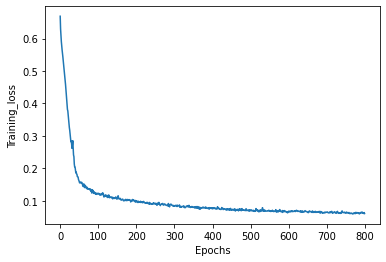

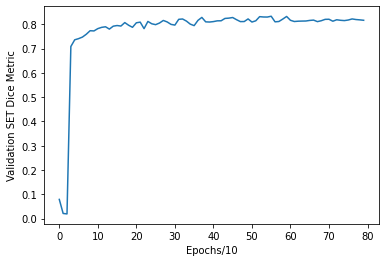

In [15]:
train_loss = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/epoch_loss_baseline.npy")
val_metric = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/metric_values_baseline.npy")

train_loss_1 = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/epoch_loss.npy")
val_metric_1 = np.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/metric_values.npy")

train_loss = np.concatenate((train_loss, train_loss_1))
val_metric = np.concatenate((val_metric, val_metric_1))

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training_loss")
plt.show()
plt.plot(val_metric)
plt.xlabel("Epochs/10")
plt.ylabel("Validation SET Dice Metric")
plt.show()

In [16]:
print("Dice Metric for best model:", np.max(val_metric)*100)

Dice Metric for best model: 83.32579731941223


# Inference

### ROI size (160,160,160)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
)
model = UNet(**UNet_meatdata).to(device)
model.load_state_dict(torch.load("/scratch/scratch6/akansh12/challenges/parse2022/temp/best_metric_model_Unet_1000_hu.pth"))

<All keys matched successfully>

In [124]:
eg_1 = next(iter(val_loader), 0)
eg_2 = next(iter(val_loader))
eg_3 = next(iter(val_loader), 3)
eg_4 = next(iter(val_loader), 4)

roi_size = (160, 160, 160)
sw_batch_size = 4

In [125]:
np.unique(eg_1['labels'] == eg_2['labels'])

array([ True])

In [89]:
with torch.no_grad():
    eg_1_outputs = torch.argmax(sliding_window_inference(eg_1['images'], roi_size, sw_batch_size, model), dim = 1).float()[0]
    eg_2_outputs = torch.argmax(sliding_window_inference(eg_2['images'], roi_size, sw_batch_size, model), dim = 1).float()[0]
    eg_3_outputs = torch.argmax(sliding_window_inference(eg_3['images'], roi_size, sw_batch_size, model), dim = 1).float()[0]
    eg_4_outputs = torch.argmax(sliding_window_inference(eg_4['images'], roi_size, sw_batch_size, model), dim = 1).float()[0]

Text(0.5, 1.0, 'Overlap')

<Figure size 1440x1440 with 0 Axes>

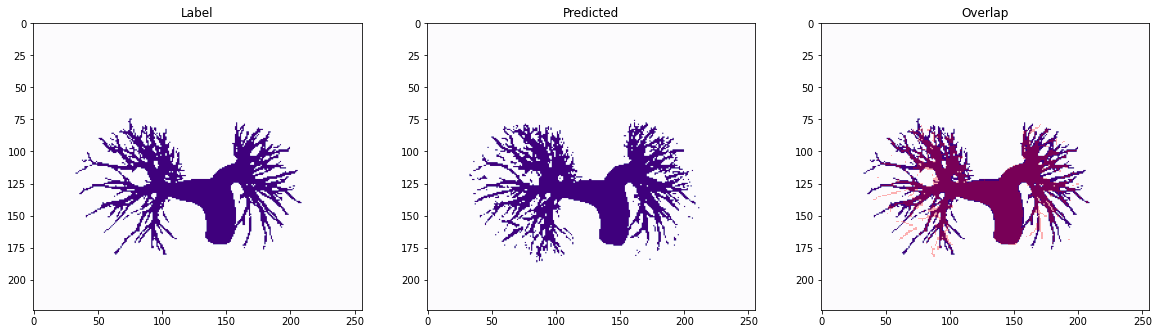

<Figure size 1440x1440 with 0 Axes>

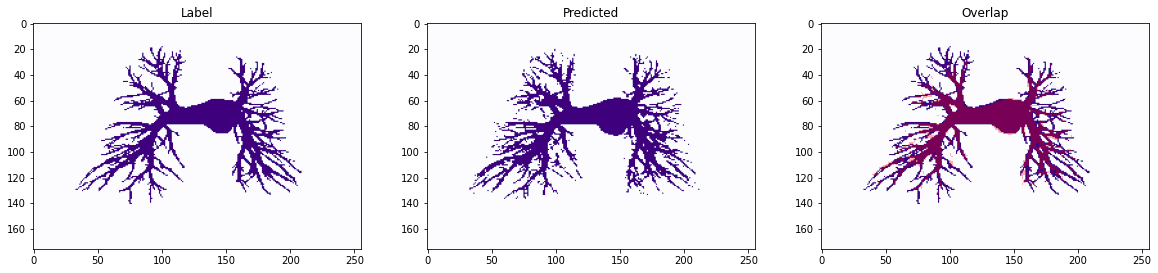

<Figure size 1440x1440 with 0 Axes>

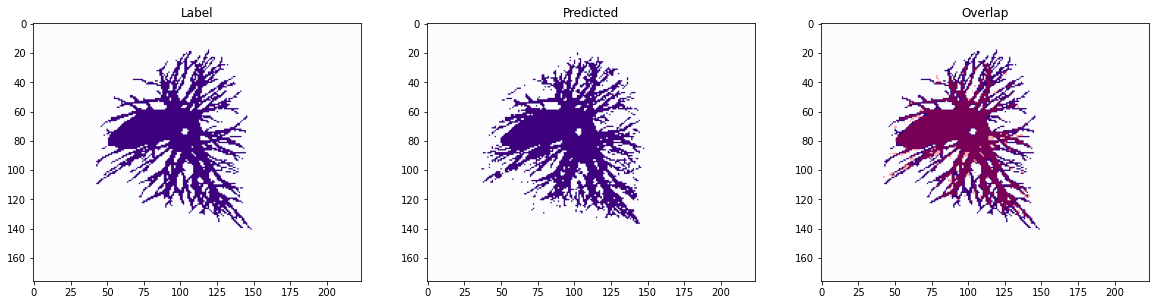

In [148]:
### 
plt.figure(figsize=(20,20))
inputs = [eg_1,eg_2,eg_3]
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 2)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(outputs[i].sum(axis = 2)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 2)>0), cmap = 'Purples');
mask_ = np.ma.masked_where(outputs[i].sum(axis = 2) ==0, outputs[i].sum(axis = 2)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")

###
plt.figure(figsize=(20,20))
inputs = [eg_1,eg_2,eg_3]
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 1)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(outputs[i].sum(axis = 1)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 1)>0), cmap = 'Purples');
mask_ = np.ma.masked_where(outputs[i].sum(axis = 1) ==0, outputs[i].sum(axis = 1)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")

###65
plt.figure(figsize=(20,20))
inputs = [eg_1,eg_2,eg_3]
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 0)>0), cmap = 'Purples')
plt.title("Label")
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(outputs[i].sum(axis = 0)>0), cmap = 'Purples');
plt.title("Predicted")
plt.subplot(1, 3, 3)

plt.imshow(np.rot90(inputs[i]['labels'][0][0].sum(axis = 0)>0), cmap = 'Purples');
mask_ = np.ma.masked_where(outputs[i].sum(axis = 0) ==0, outputs[i].sum(axis = 0)>0)
plt.imshow(np.rot90(mask_), alpha=0.3, cmap = "autumn")
plt.title("Overlap")

### ROI (96,96,96)

In [28]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

In [13]:
metric_values = []
model.eval()
with torch.no_grad():
    for index, val_data in enumerate(tqdm(val_loader)):

        val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
print(metric)

  0%|          | 0/9 [00:00<?, ?it/s]

NameError: name 'dice_metric' is not defined

## ROI Train(160,160,160)  and Test(256,256,256) 
## ROI Train(192,192,192) and Test(256,256,256) 

In [3]:
val_transforms = Compose(
    [
        LoadImaged(keys=["images", "labels"]),
        EnsureChannelFirstd(keys=["images", "labels"]),
        Orientationd(keys=["images", "labels"], axcodes="LPS"),

        ScaleIntensityRanged(
            keys=["images"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["images", "labels"], source_key="images"),
        EnsureTyped(keys=["images", "labels"]),
    ]
)

val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 4
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=4)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.86s/it]


In [4]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
from collections import OrderedDict
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
    )

model = UNet(**UNet_meatdata).to(device)
path2weights = "/scratch/scratch6/akansh12/challenges/parse2022/temp/selected_models/unet_1000_hu_160_w_augmentations_8551.pth"
state_dict = torch.load(path2weights, map_location='cpu')

for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)




<All keys matched successfully>

In [49]:
# post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
# post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
# dice_metric = DiceMetric(include_background=False, reduction="mean")
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [50]:
metric_values = []
model.eval()
with torch.no_grad():
    for index, val_data in enumerate(tqdm(val_loader)):

        val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
        roi_size = (256, 256, 256)
        sw_batch_size = 8
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model_1)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        print(dice_metric(y_pred=val_outputs, y=val_labels))

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
print(metric)

  0%|          | 0/9 [00:00<?, ?it/s]

tensor([[0.8956]])
tensor([[0.8811]])
tensor([[0.8083]])
tensor([[0.8185]])
tensor([[0.7947]])
tensor([[0.8578]])
tensor([[0.8994]])
tensor([[0.8585]])
tensor([[0.8500]])
0.8515574932098389


In [3]:
tensor([[0.9024]])
tensor([[0.8971]])
tensor([[0.7806]])
tensor([[0.8102]])
tensor([[0.7642]])
tensor([[0.8840]])
tensor([[0.9089]])
tensor([[0.8705]])
tensor([[0.8717]])
0.854412317276001

0.877725

In [ ]:
tensor([[0.9047]])
tensor([[0.8998]])
tensor([[0.7820]])
tensor([[0.8081]])
tensor([[0.7740]])
tensor([[0.8761]])
tensor([[0.9094]])
tensor([[0.8554]])
tensor([[0.8700]])
0.8532838821411133

## ROI Train(192,192,192)  and Test(256,256,256) 

In [33]:
val_transforms = Compose(
    [
        LoadImaged(keys=["images", "labels"]),
        EnsureChannelFirstd(keys=["images", "labels"]),
        Orientationd(keys=["images", "labels"], axcodes="LPS"),

        ScaleIntensityRanged(
            keys=["images"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["images", "labels"], source_key="images"),
        EnsureTyped(keys=["images", "labels"]),
    ]
)

val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 4
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=4)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.00s/it]


In [34]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
from collections import OrderedDict
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
    )

model = UNet(**UNet_meatdata).to(device)
path2weights = "/scratch/scratch6/akansh12/challenges/parse2022/temp/Unet_1000_no_hu_spacing_192_augmentations_loss_ce.pth"
state_dict = torch.load(path2weights, map_location='cpu')

for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)

<All keys matched successfully>

In [35]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [36]:
metric_values = []
model.eval()
with torch.no_grad():
    for index, val_data in enumerate(tqdm(val_loader)):

        val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
        roi_size = (256, 256, 256)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        print(dice_metric(y_pred=val_outputs, y=val_labels))
        

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
print(metric)

  0%|          | 0/9 [00:00<?, ?it/s]

tensor([[0.8589]])
tensor([[0.8474]])
tensor([[0.7507]])
tensor([[0.7754]])


KeyboardInterrupt: 

## Connected Component Analysis

### Original

In [32]:
dice_metric = DiceMetric(include_background=False, reduction="mean")
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
# post_pred = Compose([EnsureType(), KeepLargestConnectedComponent(),AsDiscrete(argmax=True)])
# post_label = Compose([EnsureType()])

In [33]:
val_transforms = Compose(
    [
        LoadImaged(keys=["images", "labels"]),
        EnsureChannelFirstd(keys=["images", "labels"]),
        Orientationd(keys=["images", "labels"], axcodes="LPS"),
        Spacingd(keys=["images", "labels"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["images"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["images", "labels"], source_key="images"),
        EnsureTyped(keys=["images", "labels"]),
    ]
)

val_ds = CacheDataset(
    data = val_files, transform = val_transforms,
    cache_rate = 1.0, num_workers = 4
)
val_loader = DataLoader(val_ds, batch_size = 1, shuffle = False, num_workers=4)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.69s/it]


In [34]:
metric_values = []
model.eval()
with torch.no_grad():
    for index, val_data in enumerate(tqdm(val_loader)):

        val_inputs, val_labels = val_data['images'].to(device), val_data['labels'].to(device)
        roi_size = (192, 192, 192)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    dice_metric.reset()
print(metric)

  0%|          | 0/9 [00:00<?, ?it/s]

0.8267951607704163


### Largest Component

In [22]:
#0.8267951607704163

128